# Практический кейс «Прогнозирование конечных свойств новых материалов (композиционных материалов)». 

***Задачи, решение которых отражено в данном ноутбуке:***
- Разведочный анализ;
- Предобработка данных;
- Обучение моделей ML.

***Цель работы:*** 
- разработать модели для прогноза модуля упругости при растяжении и прочности при растяжении

# Импорты

In [133]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout

import pickle

%matplotlib inline

In [26]:
!python --version

Python 3.11.7


In [27]:
!jupyter notebook --version

6.5.7


### Версии библиотек

 - pandas: '2.1.4'
 - numpy: '1.26.4'
 - matplotlib: '3.8.0'
 - seaborn: '0.13.2'
 - scikit-learn: '1.5.1'
 - tensorflow: '2.17.0'

# Разведочный анализ данных

Загружаем таблицы формата Excel в два Пандас Датафрейма:

In [28]:
url_bp = 'https://raw.githubusercontent.com/tatiSmol/composite_materials/main/data/X_bp.xlsx'
bp_df = pd.read_excel(url_bp, engine='openpyxl', index_col=0)

In [29]:
bp_df.head()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","Модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
0,1.857143,2030.0,738.736842,30.00,22.267857,100.000000,210.0,70.0,3000.0,220.0
1,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0
2,1.857143,2030.0,738.736842,49.90,33.000000,284.615385,210.0,70.0,3000.0,220.0
3,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0
4,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0


In [30]:
url_nup = 'https://raw.githubusercontent.com/tatiSmol/composite_materials/main/data/X_nup.xlsx'
nup_df = pd.read_excel(url_nup, engine='openpyxl', index_col=0)

In [31]:
nup_df.head()

,"Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0,4.0,57.0
1,0,4.0,60.0
2,0,4.0,70.0
3,0,5.0,47.0
4,0,5.0,57.0


Проверим размерность в двух таблицах:

In [32]:
print(f"Количество строк ({bp_df.shape[0]}) и признаков ({bp_df.shape[1]}) в X_bp dataframe")
print(f"Количество строк ({nup_df.shape[0]}) и признаков ({nup_df.shape[1]}) в X_nup dataframe")

Количество строк (1023) и признаков (10) в X_bp dataframe
Количество строк (1040) и признаков (3) в X_nup dataframe


*Второй датафрейм имеет больше значений. Во время объединения по индексу, 17 последних значений учтены не будут.*

In [33]:
# Inner Join

df = bp_df.join(nup_df, how='inner')

In [34]:
df.head()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","Модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.857143,2030.0,738.736842,30.00,22.267857,100.000000,210.0,70.0,3000.0,220.0,0,4.0,57.0
1,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0,0,4.0,60.0
2,1.857143,2030.0,738.736842,49.90,33.000000,284.615385,210.0,70.0,3000.0,220.0,0,4.0,70.0
3,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0,0,5.0,47.0
4,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,57.0


Проверим размерность нового датафрейма:

In [35]:
print(f"Количество строк ({df.shape[0]}) и признаков ({df.shape[1]}) в df dataframe")

Количество строк (1023) и признаков (13) в df dataframe


Проверим типы признаков:

In [36]:
df.dtypes

Соотношение матрица-наполнитель         float64
Плотность, кг/м3                        float64
Модуль упругости, ГПа                   float64
Количество отвердителя, м.%             float64
Содержание эпоксидных групп,%_2         float64
Температура вспышки, С_2                float64
Поверхностная плотность, г/м2           float64
Модуль упругости при растяжении, ГПа    float64
Прочность при растяжении, МПа           float64
Потребление смолы, г/м2                 float64
Угол нашивки, град                        int64
Шаг нашивки                             float64
Плотность нашивки                       float64
dtype: object

*Признаки не нуждаются в преобразовании, на данный момент, так как они все имеют числовой тип.*

Проверим на количество пропусков:

In [37]:
df.isna().sum()

Соотношение матрица-наполнитель         0
Плотность, кг/м3                        0
Модуль упругости, ГПа                   0
Количество отвердителя, м.%             0
Содержание эпоксидных групп,%_2         0
Температура вспышки, С_2                0
Поверхностная плотность, г/м2           0
Модуль упругости при растяжении, ГПа    0
Прочность при растяжении, МПа           0
Потребление смолы, г/м2                 0
Угол нашивки, град                      0
Шаг нашивки                             0
Плотность нашивки                       0
dtype: int64

*Данные достаточно полные.*

Проверим на количество уникальных значений:

In [38]:
df.nunique()

Соотношение матрица-наполнитель         1014
Плотность, кг/м3                        1013
Модуль упругости, ГПа                   1020
Количество отвердителя, м.%             1005
Содержание эпоксидных групп,%_2         1004
Температура вспышки, С_2                1003
Поверхностная плотность, г/м2           1004
Модуль упругости при растяжении, ГПа    1004
Прочность при растяжении, МПа           1004
Потребление смолы, г/м2                 1003
Угол нашивки, град                         2
Шаг нашивки                              989
Плотность нашивки                        988
dtype: int64

*Признак "Угол нашивки, град" имеет всего два уникальных значения и может быть преобразован в бинарный тип, если это будет полезно при дальнейшей работе.*

Посмотрим сводную статистику в нашем датафрейме, в более удобночитаемом виде:

In [39]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,1023.0,2.930366,0.913222,0.389403,2.317887,2.906878,3.552660,5.591742
"Плотность, кг/м3",1023.0,1975.734888,73.729231,1731.764635,1924.155467,1977.621657,2021.374375,2207.773481
"Модуль упругости, ГПа",1023.0,739.923233,330.231581,2.436909,500.047452,739.664328,961.812526,1911.536477
"Количество отвердителя, м.%",1023.0,110.570769,28.295911,17.740275,92.443497,110.564840,129.730366,198.953207
"Содержание эпоксидных групп,%_2",1023.0,22.244390,2.406301,14.254985,20.608034,22.230744,23.961934,33.000000
"Температура вспышки, С_2",1023.0,285.882151,40.943260,100.000000,259.066528,285.896812,313.002106,413.273418
"Поверхностная плотность, г/м2",1023.0,482.731833,281.314690,0.603740,266.816645,451.864365,693.225017,1399.542362
"Модуль упругости при растяжении, ГПа",1023.0,73.328571,3.118983,64.054061,71.245018,73.268805,75.356612,82.682051
"Прочность при растяжении, МПа",1023.0,2466.922843,485.628006,1036.856605,2135.850448,2459.524526,2767.193119,3848.436732
"Потребление смолы, г/м2",1023.0,218.423144,59.735931,33.803026,179.627520,219.198882,257.481724,414.590628


Визуализируем распределение значений:

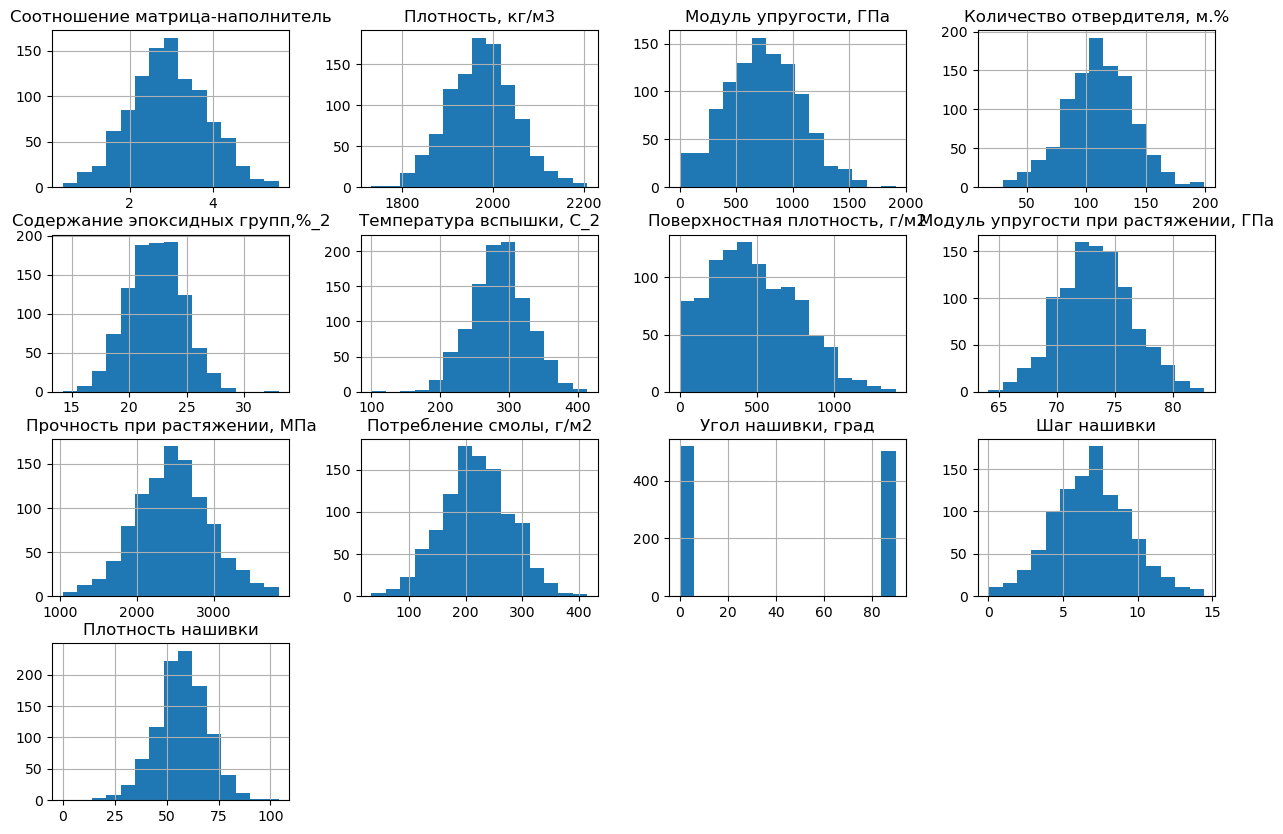

In [40]:
df.hist(bins=15, figsize=(15, 10))
plt.show()

*Значения, в целом, нормально распределены, но для работы с ними потребуется нормализация/стандартизация.*

Масштабируем признаки, чтобы наглядно построить "ящики с усами" для каждой переменной:

In [41]:
scaler = MinMaxScaler()
scaler.fit(df)

MinMaxScaler()

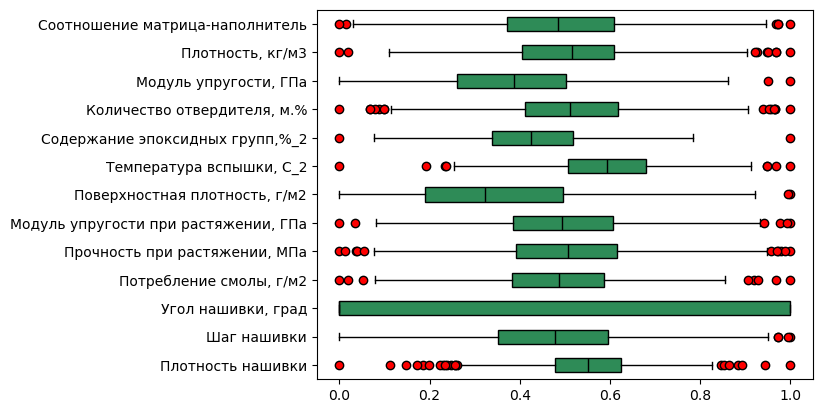

In [42]:
plt.boxplot(pd.DataFrame(scaler.transform(df)), 
            labels=df.columns, 
            patch_artist=True, 
            meanline=True, 
            vert=False, 
            boxprops=dict(facecolor='seagreen', color='black'), 
            medianprops=dict(color='black'), 
            whiskerprops=dict(color='black'), 
            capprops=dict(color = 'black'), 
            flierprops=dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
           )
plt.gca().invert_yaxis()
plt.show()

*Признаки имеют довольно много выбросов, но с этим мы поработаем на следующем этапе.*

Визуализируем общую корреляцию между признаками:

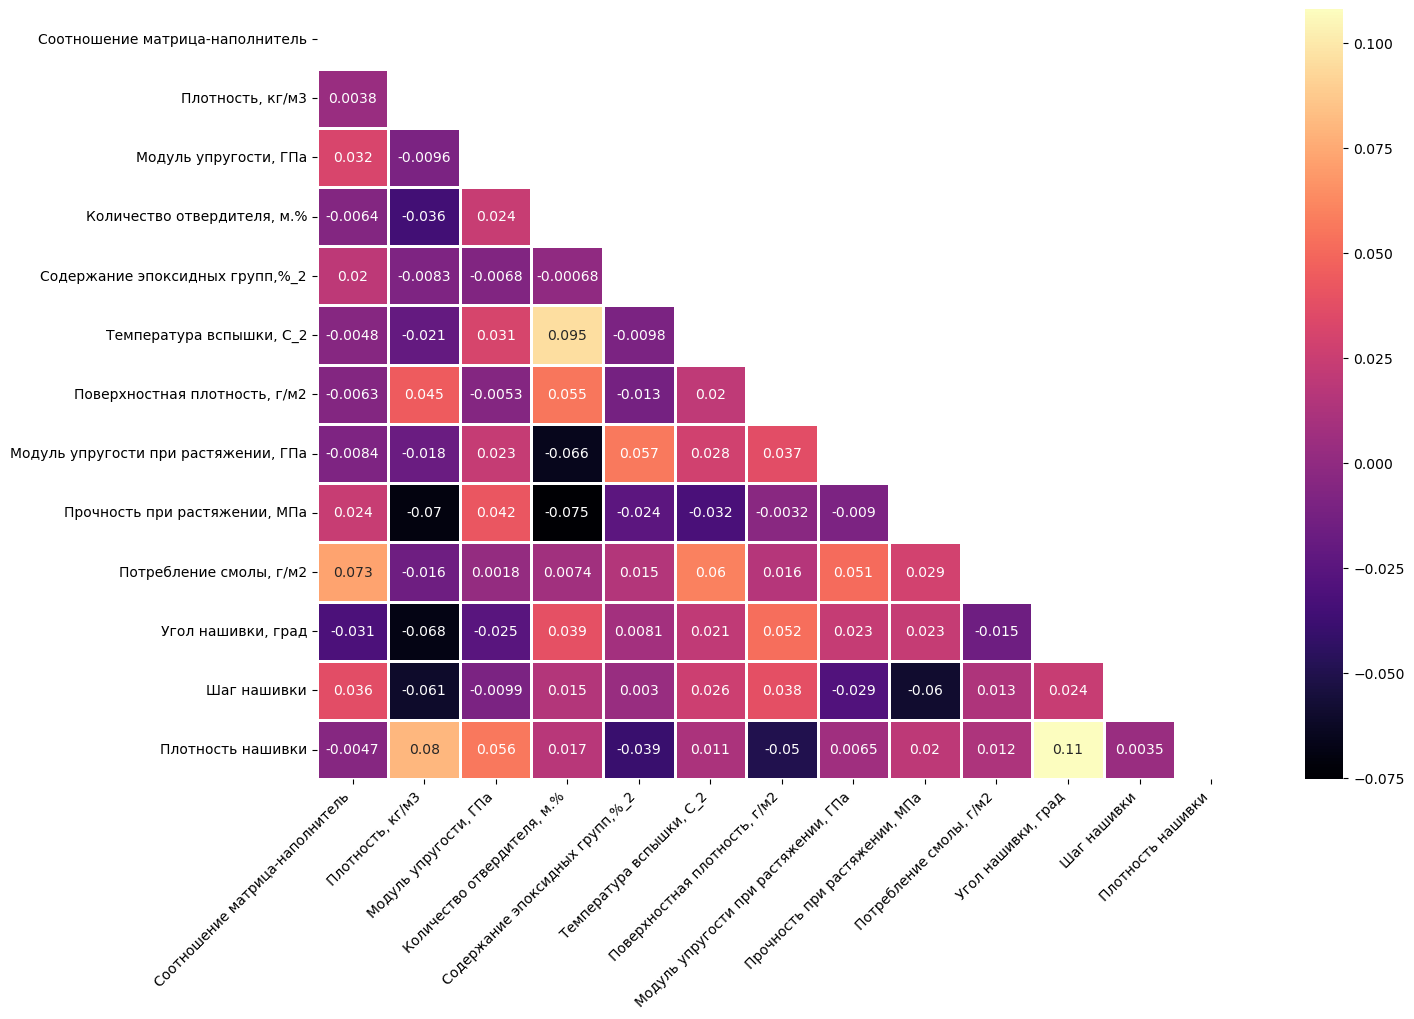

In [43]:
matrix = np.triu(df.corr())
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot = True, cmap= 'magma', linewidths=1, linecolor='white', mask = matrix)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

*К сожалению,общих корреляций очень мало, что даёт понять, что будет сложно работать с представленными данными.*

# Предобработка данных

Разделим данные на обучающую и тестовую выборки:

In [44]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

Обработку выбросов мы будем делать при помощи метода межквартильного размаха. Подготовим метод:

In [45]:
def iqr_method(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

## Работа с выбросами в обучающей выборке

Масштабируем обучающую выборку, для более удобной работы:

In [46]:
scaler = MinMaxScaler()
scaler.fit(train_df)

MinMaxScaler()

Визуализируем и посчитаем выбросы в обучающей выборке:

In [47]:
scaled_df = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
outliers = {}
total = 0

for column in scaled_df:
    Q1 = scaled_df[column].quantile(0.25)
    Q3 = scaled_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers[column] = ((scaled_df[column] < lower_bound) | (scaled_df[column] > upper_bound)).sum()
    total += outliers[column]

print(pd.DataFrame.from_dict(outliers, orient='index', columns=['Outliers']))
print("Общее количество возможных выбросов: ", total)

                                      Outliers
Соотношение матрица-наполнитель              5
Плотность, кг/м3                             5
Модуль упругости, ГПа                        3
Количество отвердителя, м.%                 10
Содержание эпоксидных групп,%_2              2
Температура вспышки, С_2                     9
Поверхностная плотность, г/м2                1
Модуль упругости при растяжении, ГПа         5
Прочность при растяжении, МПа                7
Потребление смолы, г/м2                      7
Угол нашивки, град                           0
Шаг нашивки                                  4
Плотность нашивки                           19
Общее количество возможных выбросов:  77


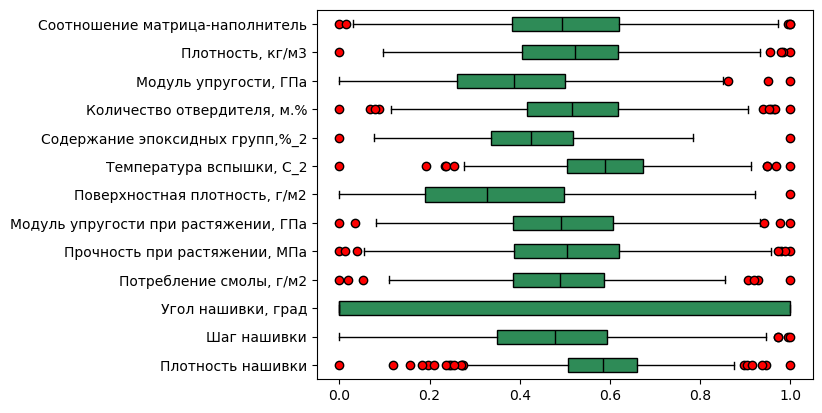

In [48]:
plt.boxplot(pd.DataFrame(scaler.transform(train_df)), 
            labels=df.columns, 
            patch_artist=True, 
            meanline=True, 
            vert=False, 
            boxprops=dict(facecolor='seagreen', color='black'), 
            medianprops=dict(color='black'), 
            whiskerprops=dict(color='black'), 
            capprops=dict(color = 'black'), 
            flierprops=dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
           )
plt.gca().invert_yaxis()
plt.show()

In [49]:
print('Количество значений в признаках: ', train_df.shape[0])

Количество значений в признаках:  818


Обработаем выбросы:

In [50]:
train_df = iqr_method(train_df, train_df.columns)

In [51]:
print('Количество значений в признаках: ', train_df.shape[0])

Количество значений в признаках:  746


*Количество значений уменьшилось на **72 единицы**.*

Посмотрим на результаты после обработки:

In [52]:
scaled_df = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
outliers = {}
total = 0

for column in scaled_df:
    Q1 = scaled_df[column].quantile(0.25)
    Q3 = scaled_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers[column] = ((scaled_df[column] < lower_bound) | (scaled_df[column] > upper_bound)).sum()
    total += outliers[column]

print(pd.DataFrame.from_dict(outliers, orient='index', columns=['Outlier Count']))
print("Общее количество возможных выбросов: ", total)

                                      Outlier Count
Соотношение матрица-наполнитель                   4
Плотность, кг/м3                                  0
Модуль упругости, ГПа                             0
Количество отвердителя, м.%                       0
Содержание эпоксидных групп,%_2                   0
Температура вспышки, С_2                          0
Поверхностная плотность, г/м2                     0
Модуль упругости при растяжении, ГПа              1
Прочность при растяжении, МПа                     0
Потребление смолы, г/м2                           0
Угол нашивки, град                                0
Шаг нашивки                                       0
Плотность нашивки                                 3
Общее количество возможных выбросов:  8


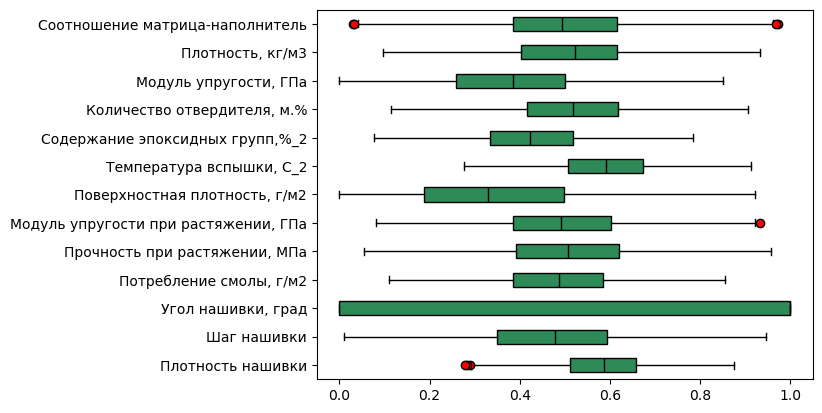

In [53]:
plt.boxplot(pd.DataFrame(scaler.transform(train_df)), 
            labels=df.columns, 
            patch_artist=True, 
            meanline=True, 
            vert=False, 
            boxprops=dict(facecolor='seagreen', color='black'), 
            medianprops=dict(color='black'), 
            whiskerprops=dict(color='black'), 
            capprops=dict(color = 'black'), 
            flierprops=dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
           )
plt.gca().invert_yaxis()
plt.show()

*Количество выбросов заметно уменьшилось.*

## Работа с выбросами в тестовой выборке

Масштабируем тестовую выборку, для более удобной работы:

In [54]:
scaler = MinMaxScaler()
scaler.fit(test_df)

MinMaxScaler()

Визуализируем и посчитаем выбросы в тестовой выборке:

In [55]:
scaled_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)
outliers = {}
total = 0

for column in scaled_df:
    Q1 = scaled_df[column].quantile(0.25)
    Q3 = scaled_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers[column] = ((scaled_df[column] < lower_bound) | (scaled_df[column] > upper_bound)).sum()
    total += outliers[column]

print(pd.DataFrame.from_dict(outliers, orient='index', columns=['Outlier Count']))
print("Общее количество возможных выбросов: ", total)

                                      Outlier Count
Соотношение матрица-наполнитель                   0
Плотность, кг/м3                                  3
Модуль упругости, ГПа                             0
Количество отвердителя, м.%                       2
Содержание эпоксидных групп,%_2                   1
Температура вспышки, С_2                          0
Поверхностная плотность, г/м2                     1
Модуль упругости при растяжении, ГПа              1
Прочность при растяжении, МПа                     7
Потребление смолы, г/м2                           1
Угол нашивки, град                                0
Шаг нашивки                                       0
Плотность нашивки                                 2
Общее количество возможных выбросов:  18


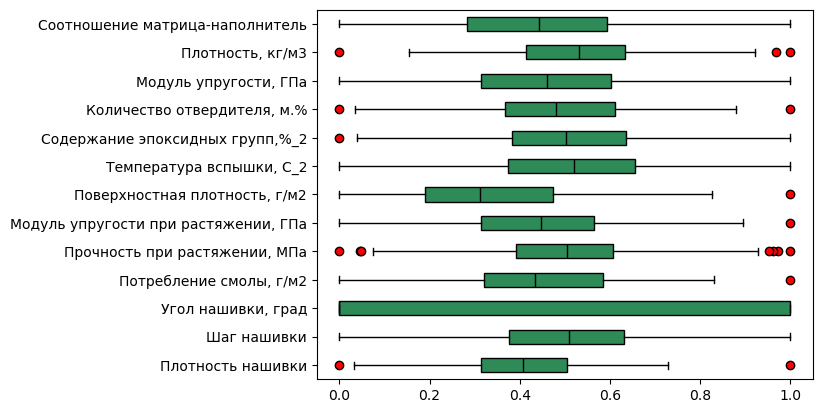

In [56]:
plt.boxplot(pd.DataFrame(scaler.transform(test_df)), 
            labels=df.columns, 
            patch_artist=True, 
            meanline=True, 
            vert=False, 
            boxprops=dict(facecolor='seagreen', color='black'), 
            medianprops=dict(color='black'), 
            whiskerprops=dict(color='black'), 
            capprops=dict(color = 'black'), 
            flierprops=dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
           )
plt.gca().invert_yaxis()
plt.show()

*Количество выбросов не столь велико, поэтому пока попробуем поработать без обработки тестовых данных (так как это, в принципе, не обязательно).*

Нормализуем данные по параметрам обучающей выборки:

In [57]:
scaler = MinMaxScaler()
scaler.fit(train_df)

train_df_norm = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
test_df_norm = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

# Машинное обучение

Разделим тренировочную выборку для модуля упругости при растяжении и прочности при растяжении:

In [58]:
X_train, y_train_modulus, y_train_strength = (
    train_df_norm.drop(columns=['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']), 
    train_df_norm['Модуль упругости при растяжении, ГПа'], 
    train_df_norm['Прочность при растяжении, МПа']
)

Разделим тестовую выборку для модуля упругости при растяжении и прочности при растяжении:

In [59]:
X_test, y_test_modulus, y_test_strength = (
    test_df_norm.drop(columns=['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']), 
    test_df_norm['Модуль упругости при растяжении, ГПа'], 
    test_df_norm['Прочность при растяжении, МПа']
)

Проверим размерности:

In [60]:
print("X_train: ", X_train.shape, ", y_train_modulus: ", y_train_modulus.shape, ", y_train_strength: ", y_train_strength.shape)
print("X_test: ", X_test.shape, ", y_test_modulus: ", y_test_modulus.shape, ", y_test_strength: ", y_test_strength.shape)

X_train:  (746, 11) , y_train_modulus:  (746,) , y_train_strength:  (746,)
X_test:  (205, 11) , y_test_modulus:  (205,) , y_test_strength:  (205,)


Подготовим также тренировочную и тестовую выбоки соотношения матрица-наполнитель:

In [61]:
X_train_matrix, y_train_matrix = train_df_norm.drop(columns='Соотношение матрица-наполнитель'
), train_df_norm['Соотношение матрица-наполнитель']

X_test_matrix, y_test_matrix = test_df_norm.drop(columns='Соотношение матрица-наполнитель'
), test_df_norm['Соотношение матрица-наполнитель']

Проверим размерности:

In [62]:
print('X_train_matrix: ', X_train_matrix.shape, 'y_train_matrix: ', y_train_matrix.shape)
print('X_test_matrix: ', X_test_matrix.shape, 'y_test_matrix: ', y_test_matrix.shape)

X_train_matrix:  (746, 12) y_train_matrix:  (746,)
X_test_matrix:  (205, 12) y_test_matrix:  (205,)


## Алгоритм машинного обучения для определения значений модуля упругости при растяжении и прочности при растяжении

Визуализируем общую корреляцию признаков, после всех наших прошлых действий:

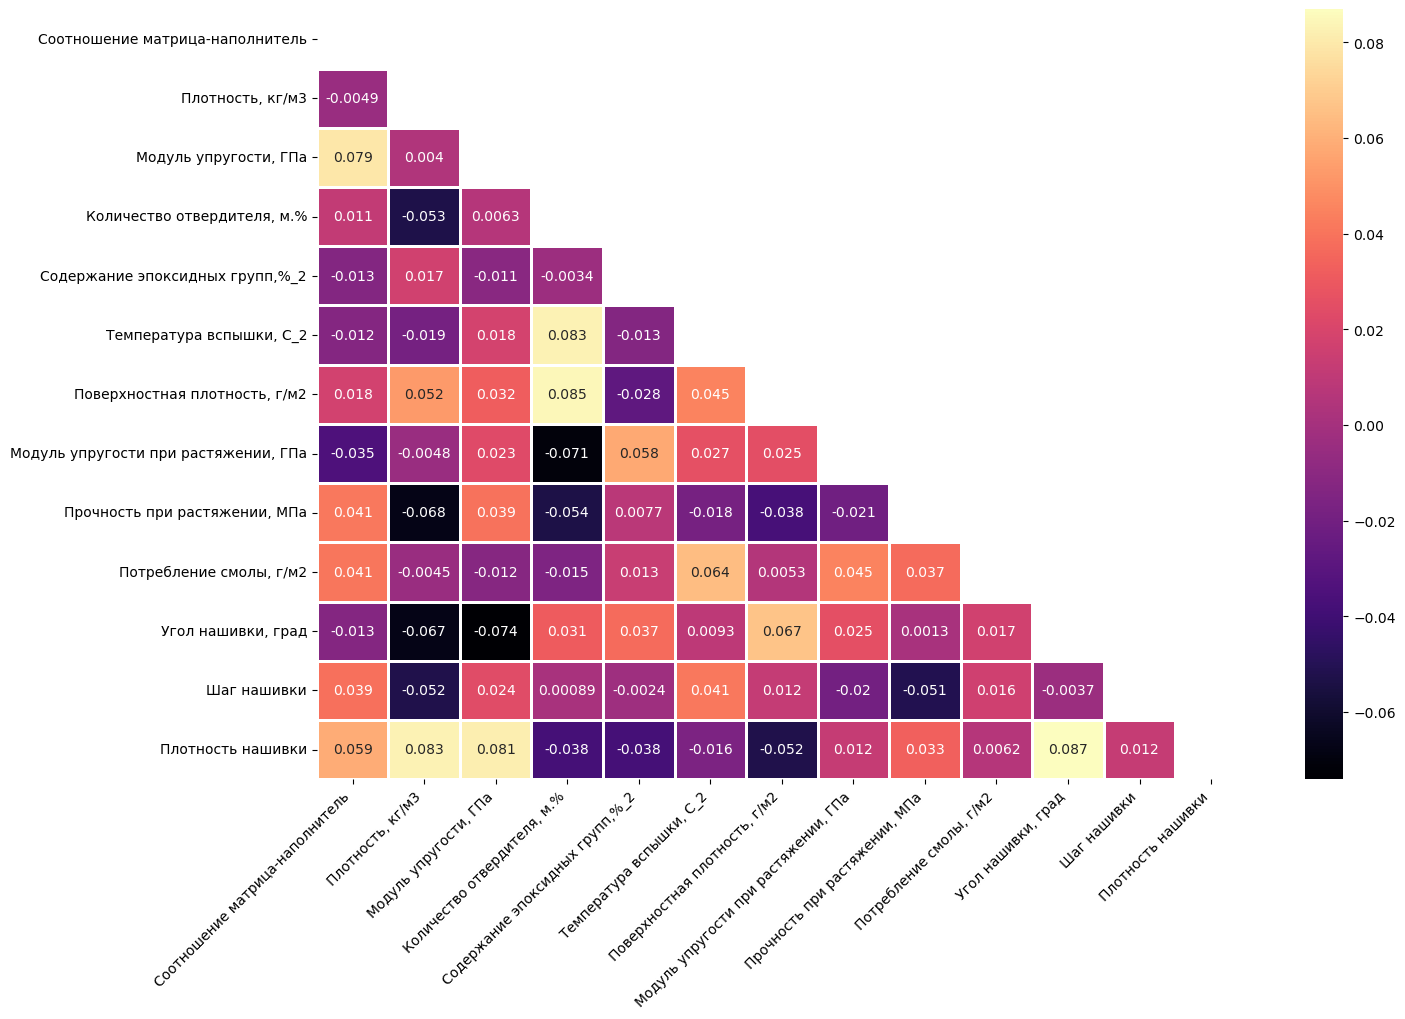

In [63]:
matrix = np.triu(train_df_norm.corr())
plt.figure(figsize=(15, 10))
sns.heatmap(train_df_norm.corr(), annot = True, cmap= 'magma', linewidths=1, linecolor='white', mask = matrix)
plt.xticks(rotation = 45, ha = 'right')
plt.show()

In [64]:
correlations = train_df_norm.corr()

Посмотрим корреляцию признаков с модулем упругости при растяжении:

In [65]:
print(correlations['Модуль упругости при растяжении, ГПа'].sort_values(ascending=False))

Модуль упругости при растяжении, ГПа    1.000000
Содержание эпоксидных групп,%_2         0.057674
Потребление смолы, г/м2                 0.045097
Температура вспышки, С_2                0.026531
Угол нашивки, град                      0.025466
Поверхностная плотность, г/м2           0.024953
Модуль упругости, ГПа                   0.023114
Плотность нашивки                       0.012372
Плотность, кг/м3                       -0.004786
Шаг нашивки                            -0.019806
Прочность при растяжении, МПа          -0.020880
Соотношение матрица-наполнитель        -0.035019
Количество отвердителя, м.%            -0.070878
Name: Модуль упругости при растяжении, ГПа, dtype: float64


А теперь корреляцию признаков с прочностью при растяжении:

In [66]:
print(correlations['Прочность при растяжении, МПа'].sort_values(ascending=False))

Прочность при растяжении, МПа           1.000000
Соотношение матрица-наполнитель         0.041237
Модуль упругости, ГПа                   0.039468
Потребление смолы, г/м2                 0.037074
Плотность нашивки                       0.033147
Содержание эпоксидных групп,%_2         0.007743
Угол нашивки, град                      0.001326
Температура вспышки, С_2               -0.018377
Модуль упругости при растяжении, ГПа   -0.020880
Поверхностная плотность, г/м2          -0.037523
Шаг нашивки                            -0.051020
Количество отвердителя, м.%            -0.053625
Плотность, кг/м3                       -0.067698
Name: Прочность при растяжении, МПа, dtype: float64


*К сожалению, корреляции очень слабы.*

Попробуем найти общие корреляции для обоих признаков, в качестве минимального порога возьмём минимальную корреляцию из двух таблиц выше: 

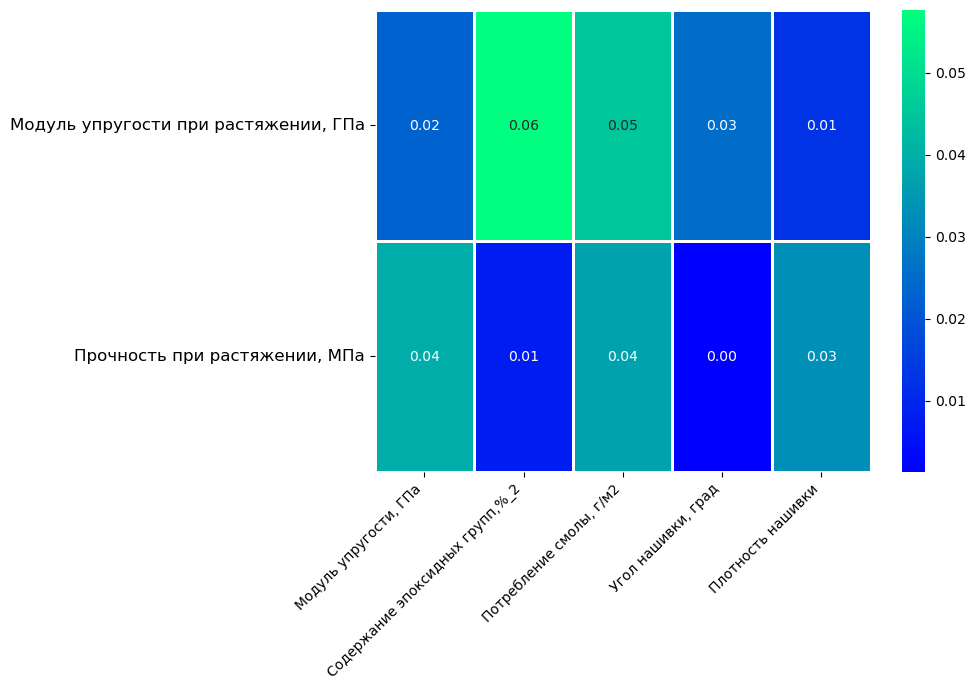

In [67]:
correlation_threshold = 0.001326
correlation_matrix = train_df_norm.corr()
target_corr = correlation_matrix[['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']]

useful_features = target_corr[
    (target_corr['Модуль упругости при растяжении, ГПа'] > correlation_threshold ) &
    (target_corr['Прочность при растяжении, МПа'] > correlation_threshold)
]

if useful_features.empty:
    print("Нет признаков с корреляцией выше заданного порога для обоих целевых признаков.")
else:
    plt.figure(figsize=(8, 6))
    sns.heatmap(useful_features.T, annot=True, cmap='winter', linewidths=1, linecolor='white', fmt=".2f",
                annot_kws={"size": 10})
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=12)
    plt.show()

*Наилучшим образом здесь себя показывают признаки "Модуль упругости, ГПа" и "Потребление смолы, г/м2", но корреляция всё равно очень и очень слаба. То есть зависимости признаков с целевыми переменными практически нет.*

Визуализируем графики ядерной оценки плотности признаков до нормализации и после:

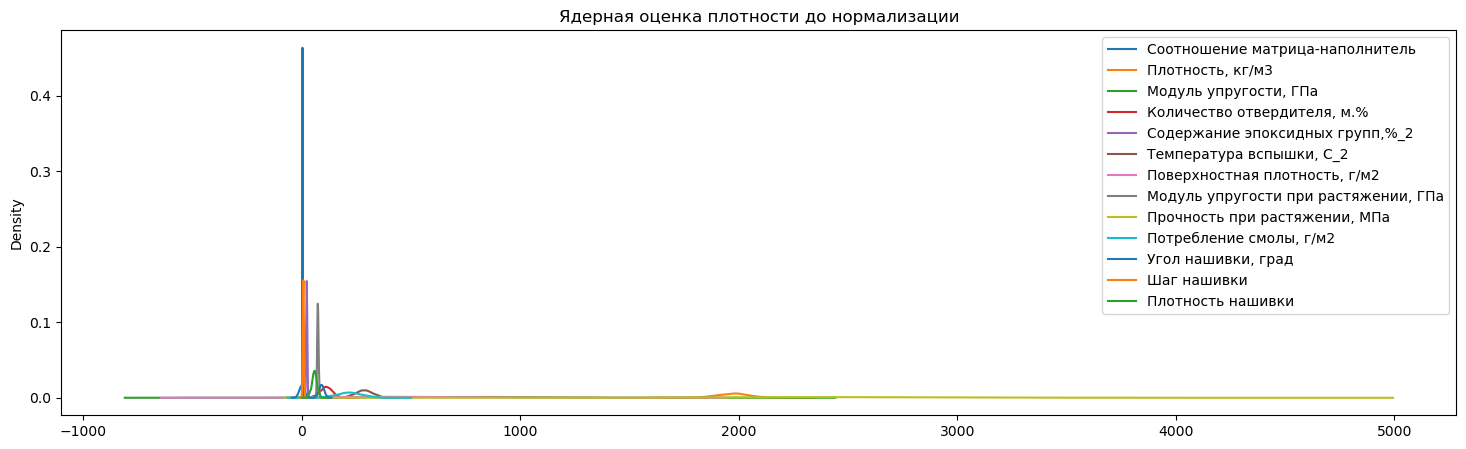

In [68]:
fig, ax = plt.subplots(figsize = (18, 5))
train_df.plot(kind = 'kde', ax = ax)
plt.title('Ядерная оценка плотности до нормализации')
plt.show()

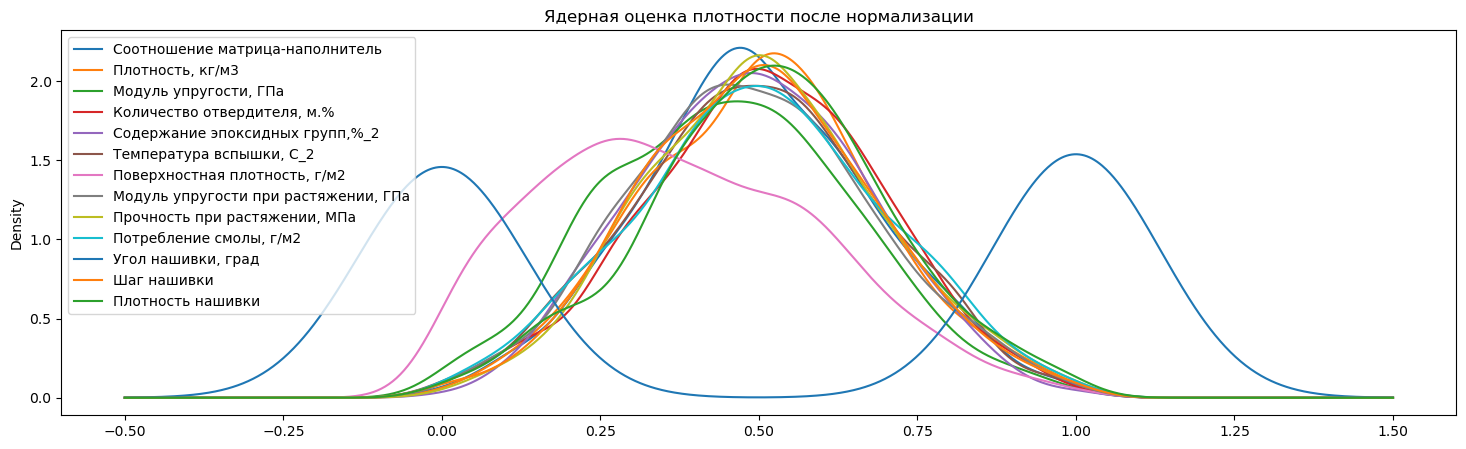

In [69]:
fig, ax = plt.subplots(figsize = (18, 5))
train_df_norm.plot(kind = 'kde', ax = ax)
plt.title('Ядерная оценка плотности после нормализации')
plt.show()

*При сравнении двух графиков видно, что нормализация прошла довольно успешно. В связи с малым количеством значений и слабой корреляцией целевых переменных и остальных признаков, мало что можно сделать ещё. Попробуем перейти наконец к непосредственной задаче.*

### Первая гипотеза

Итак, наша первая гипотеза будет звучать так:    
*Несмотря на слабую корреляцию и малое количество изначальных данных, нам должно быть их достаточно для построения модели машинного обучения.*

#### Обучение

Для начала создадим таблицу в которую будем складывать различные метрики для работы каждой модели:

In [71]:
metrics_modulus = ['MSEm', 'MAEm', 'R²m train', 'R²m test']
metrics_strength = ['MSEs', 'MAEs', 'R²s train', 'R²s test']
models = ['RandomForestRegressor', 'LinearRegression', 'LassoCV', 'ElasticNetCV', 'RidgeCV', 'KNeighborsRegressor', 
         'GradientBoostingRegressor', 'SVR']

ms_table = pd.DataFrame(index=models, columns=metrics_modulus + metrics_strength)

In [72]:
ms_table

,MSEm,MAEm,R²m train,R²m test,MSEs,MAEs,R²s train,R²s test
RandomForestRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LinearRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LassoCV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ElasticNetCV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RidgeCV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KNeighborsRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GradientBoostingRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SVR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Затем создадим специальные методы, чтобы проще было конструировать разные модели:

In [73]:
def create_modulus_model(model, model_name):
    model.fit(X_train, y_train_modulus)
    y_pred_m = model.predict(X_test)
    
    # средняя квадратичная ошибка:
    mse = mean_squared_error(y_test_modulus, y_pred_m)
    ms_table.loc[model_name, 'MSEm'] = round(mse, 3)
    print("MSE для модуля упругости:", mse)
    
    #средняя абсолютная ошибка:
    mae = mean_absolute_error(y_test_modulus, y_pred_m)
    ms_table.loc[model_name, 'MAEm'] = round(mae, 3)
    print("MAE для модуля упругости:", mae)
    
    # коэффициент детерминации для обучающей выборки:
    r2_train = model.score(X_train, y_train_modulus)
    ms_table.loc[model_name, 'R²m train'] = round(r2_train, 3)
    print("R² на обучающей выборке для модуля упругости:", r2_train)
    
    # коэффициент детерминации для тестовой выборки:
    r2_test = r2_score(y_test_modulus, y_pred_m)
    ms_table.loc[model_name, 'R²m test'] = round(r2_test, 3)
    print("R² на тестовой выборке для модуля упругости:", r2_test)


def create_strength_model(model, model_name):
    model.fit(X_train, y_train_strength)
    y_pred_s = model.predict(X_test)
    
    # средняя квадратичная ошибка:
    mse = mean_squared_error(y_test_strength, y_pred_s)
    ms_table.loc[model_name, 'MSEs'] = round(mse, 3)
    print("MSE для прочности:", mse)
    
    #средняя абсолютная ошибка:
    mae = mean_absolute_error(y_test_strength, y_pred_s)
    ms_table.loc[model_name, 'MAEs'] = round(mae, 3)
    print("MAE для прочности:", mae)
    
    # коэффициент детерминации для обучающей выборки:
    r2_train = model.score(X_train, y_train_strength)
    ms_table.loc[model_name, 'R²s train'] = round(r2_train, 3)
    print("R² на обучающей выборке для прочности:", r2_train)
    
    # коэффициент детерминации для тестовой выборки:
    r2_test = r2_score(y_test_strength, y_pred_s)
    ms_table.loc[model_name, 'R²s test'] = round(r2_test, 3)
    print("R² на тестовой выборке для прочности:", r2_test)
    

##### `RandomForestRegressor`:

Для начала подберём подходящие значения n_estimators и max_depth для моделей Случайного Леса:

In [118]:
various = {'n_estimators': [100, 200], 
           'max_depth': [5, 10, 15, 20]}

results_m = GridSearchCV(RandomForestRegressor(), various, cv=9, n_jobs=-1, verbose=1)
results_m.fit(X_train, y_train_modulus)
print("Лучшее значение n_estimators для модуля упругости: ", results_m.best_params_)

results_s = GridSearchCV(RandomForestRegressor(), various, cv=9, n_jobs=-1, verbose=1)
results_s.fit(X_train, y_train_strength)
print("Лучшее значение n_estimators для прочности: ", results_s.best_params_)

Fitting 9 folds for each of 8 candidates, totalling 72 fits
Лучшее значение n_estimators для модуля упругости:  {'max_depth': 5, 'n_estimators': 200}
Fitting 9 folds for each of 8 candidates, totalling 72 fits
Лучшее значение n_estimators для прочности:  {'max_depth': 5, 'n_estimators': 200}


In [74]:
model_rf = RandomForestRegressor(max_depth=5, n_estimators=200)

In [75]:
create_modulus_model(model_rf, "RandomForestRegressor")

MSE для модуля упругости: 0.038981873466557196
MAE для модуля упругости: 0.15889811751988323
R² на обучающей выборке для модуля упругости: 0.23891648436658153
R² на тестовой выборке для модуля упругости: -0.04693035704406112


In [76]:
create_strength_model(model_rf, "RandomForestRegressor")

MSE для прочности: 0.03344005106706112
MAE для прочности: 0.14358515951665937
R² на обучающей выборке для прочности: 0.2568106995532322
R² на тестовой выборке для прочности: 0.0080089466538944


##### `LinearRegression`:

In [77]:
model_lr = LinearRegression()

In [78]:
create_modulus_model(model_lr, "LinearRegression")

MSE для модуля упругости: 0.037060500393834836
MAE для модуля упругости: 0.15447628615708295
R² на обучающей выборке для модуля упругости: 0.015319361544065102
R² на тестовой выборке для модуля упругости: 0.004671672775408253


In [79]:
create_strength_model(model_lr, "LinearRegression")

MSE для прочности: 0.03326787422608947
MAE для прочности: 0.14280742002241448
R² на обучающей выборке для прочности: 0.017640497742477557
R² на тестовой выборке для прочности: 0.013116531133797071


##### `LassoCV`

In [80]:
model_lasso = LassoCV()

In [81]:
create_modulus_model(model_lasso, "LassoCV")

MSE для модуля упругости: 0.03729091180741604
MAE для модуля упругости: 0.15517440538552998
R² на обучающей выборке для модуля упругости: 0.0
R² на тестовой выборке для модуля упругости: -0.0015164521666766184


In [82]:
create_strength_model(model_lasso, "LassoCV")

MSE для прочности: 0.03371032817864773
MAE для прочности: 0.14357757321655115
R² на обучающей выборке для прочности: 0.0
R² на тестовой выборке для прочности: -8.758704284517194e-06


##### `ElasticNetCV`

In [83]:
model_en = ElasticNetCV()

In [84]:
create_modulus_model(model_en, "ElasticNetCV")

MSE для модуля упругости: 0.03729091180741604
MAE для модуля упругости: 0.15517440538552998
R² на обучающей выборке для модуля упругости: 0.0
R² на тестовой выборке для модуля упругости: -0.0015164521666766184


In [85]:
create_strength_model(model_en, "ElasticNetCV")

MSE для прочности: 0.03371032817864773
MAE для прочности: 0.14357757321655115
R² на обучающей выборке для прочности: 0.0
R² на тестовой выборке для прочности: -8.758704284517194e-06


##### `RidgeCV`

In [86]:
model_ridge = RidgeCV()

In [87]:
create_modulus_model(model_ridge, "RidgeCV")

MSE для модуля упругости: 0.03699152229123837
MAE для модуля упругости: 0.15442393382562325
R² на обучающей выборке для модуля упругости: 0.014131578258517852
R² на тестовой выборке для модуля упругости: 0.006524207380793068


In [88]:
create_strength_model(model_ridge, "RidgeCV")

MSE для прочности: 0.033266610585786574
MAE для прочности: 0.14277954245925525
R² на обучающей выборке для прочности: 0.01631016623215864
R² на тестовой выборке для прочности: 0.013154016718750272


##### `KNeighborsRegressor`

Для начала подберём подходящие значения n_neighbors для моделей KNN:

In [72]:
various = {'n_neighbors': range(1, 501)}

results_m = GridSearchCV(KNeighborsRegressor(), various, cv=9, n_jobs=-1, verbose=1)
results_m.fit(X_train, y_train_modulus)
print("Лучшее значение n_neighbors для модуля упругости: ", results_m.best_params_)

results_s = GridSearchCV(KNeighborsRegressor(), various, cv=9, n_jobs=-1, verbose=1)
results_s.fit(X_train, y_train_strength)
print("Лучшее значение n_neighbors для прочности: ", results_s.best_params_)

Fitting 9 folds for each of 500 candidates, totalling 4500 fits
Лучшее значение n_neighbors для модуля упругости:  {'n_neighbors': 206}
Fitting 9 folds for each of 500 candidates, totalling 4500 fits
Лучшее значение n_neighbors для прочности:  {'n_neighbors': 434}


In [89]:
model_knn_m = KNeighborsRegressor(n_neighbors=206)
model_knn_s = KNeighborsRegressor(n_neighbors=434)

In [90]:
create_modulus_model(model_knn_m, "KNeighborsRegressor")

MSE для модуля упругости: 0.03691074719902779
MAE для модуля упругости: 0.15390678746707437
R² на обучающей выборке для модуля упругости: 0.007379864852360529
R² на тестовой выборке для модуля упругости: 0.00869357197536147


In [91]:
create_strength_model(model_knn_s, "KNeighborsRegressor")

MSE для прочности: 0.03348482510061727
MAE для прочности: 0.1431446309570712
R² на обучающей выборке для прочности: -0.0008040476359763016
R² на тестовой выборке для прочности: 0.006680735742348731


##### `GradientBoostingRegressor`

Для начала подберём подходящие значения n_estimators, max_depth и learning_rate для градиентного бустинга:

In [113]:
various = {
    'n_estimators': [100, 200], 
    'max_depth': [3, 5, 7], 
    'learning_rate': [0.01, 0.05, 0.1]
}

results_m = GridSearchCV(GradientBoostingRegressor(), various, cv=9, n_jobs=-1, verbose=1)
results_m.fit(X_train, y_train_modulus)
print("Лучшие значения для модуля упругости: ", results_m.best_params_)

results_s = GridSearchCV(GradientBoostingRegressor(), various, cv=9, n_jobs=-1, verbose=1)
results_s.fit(X_train, y_train_strength)
print("Лучшие значения для прочности: ", results_s.best_params_)

Fitting 9 folds for each of 18 candidates, totalling 162 fits
Лучшие значения для модуля упругости:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Fitting 9 folds for each of 18 candidates, totalling 162 fits
Лучшие значения для прочности:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [92]:
model_gb = GradientBoostingRegressor(learning_rate=0.01, max_depth=3, n_estimators=100)

In [93]:
create_modulus_model(model_gb, "GradientBoostingRegressor")

MSE для модуля упругости: 0.03792645800643179
MAE для модуля упругости: 0.15631208057883922
R² на обучающей выборке для модуля упругости: 0.08458967864202371
R² на тестовой выборке для модуля упругости: -0.01858522156854714


In [94]:
create_strength_model(model_gb, "GradientBoostingRegressor")

MSE для прочности: 0.03337892080719645
MAE для прочности: 0.1446391955351469
R² на обучающей выборке для прочности: 0.09501811046429531
R² на тестовой выборке для прочности: 0.00982236107580614


##### `SVR`

Для начала подберём подходящие значения `kernel` и `C` для моделей метода опорных векторов:

In [104]:
various = {'C': np.logspace(-3, 2, 6), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

results_m = GridSearchCV(SVR(), various, cv=9, n_jobs=-1, verbose=1)
results_m.fit(X_train, y_train_modulus)
print("Лучшие значения для модуля упругости: ", results_m.best_params_)

results_s = GridSearchCV(SVR(), various, cv=9, n_jobs=-1, verbose=1)
results_s.fit(X_train, y_train_strength)
print("Лучшие значения для прочности: ", results_s.best_params_)

Fitting 9 folds for each of 24 candidates, totalling 216 fits
Лучшие значения для модуля упругости:  {'C': 0.01, 'kernel': 'rbf'}
Fitting 9 folds for each of 24 candidates, totalling 216 fits
Лучшие значения для прочности:  {'C': 0.1, 'kernel': 'sigmoid'}


In [95]:
model_svr_m = SVR(kernel='rbf', C=0.01)
model_svr_s = SVR(kernel='sigmoid', C=0.1)

In [96]:
create_modulus_model(model_svr_m, "SVR")

MSE для модуля упругости: 0.03700026959158758
MAE для модуля упругости: 0.15396444391213857
R² на обучающей выборке для модуля упругости: 0.041105989527494224
R² на тестовой выборке для модуля упругости: 0.006289282440984256


In [97]:
create_strength_model(model_svr_s, "SVR")

MSE для прочности: 0.03394422256592175
MAE для прочности: 0.14420754089182594
R² на обучающей выборке для прочности: 0.002960356683914589
R² на тестовой выборке для прочности: -0.006947179316693086


Отсортируем таблицу по результатам коэффициентов детерминации (в тестовой выборке) для обеих целевых переменных:

In [155]:
ms_table.sort_values(['R²m test', 'R²s test'], ascending=False)

,MSEm,MAEm,R²m train,R²m test,MSEs,MAEs,R²s train,R²s test
KNeighborsRegressor,0.037,0.154,0.007,0.009,0.033,0.143,-0.001,0.007
RidgeCV,0.037,0.154,0.014,0.007,0.033,0.143,0.016,0.013
SVR,0.037,0.154,0.041,0.006,0.034,0.144,0.003,-0.007
LinearRegression,0.037,0.154,0.015,0.005,0.033,0.143,0.018,0.013
LassoCV,0.037,0.155,0.0,-0.002,0.034,0.144,0.0,-0.0
ElasticNetCV,0.037,0.155,0.0,-0.002,0.034,0.144,0.0,-0.0
GradientBoostingRegressor,0.038,0.156,0.085,-0.019,0.033,0.145,0.095,0.01
RandomForestRegressor,0.039,0.158,0.238,-0.039,0.034,0.144,0.25,0.003


***Вывод:***    
Метрики очень малы; коэффициент детерминации очень мал или даже отрицателен, а это значит, что модели не научились правильно предсказывать целевые значения.

### Вторая гипотеза

Так как результаты работы по первой гипотезе весьма сложно назвать хоть сколько-нибудь подходящими, то выдвинем следующую:    
*Данные содержат много неверных вводных, поэтому тестовые данные всё же надо очистить от выбросов*.    
Посмотрим что получится.

До этого мы остановились на подсчёте и визуализации выбросов в тестовой выборке. Повторим эти шаги:

In [98]:
scaler = MinMaxScaler()
scaler.fit(test_df)

MinMaxScaler()

In [99]:
scaled_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)
outliers = {}
total = 0

for column in scaled_df:
    Q1 = scaled_df[column].quantile(0.25)
    Q3 = scaled_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers[column] = ((scaled_df[column] < lower_bound) | (scaled_df[column] > upper_bound)).sum()
    total += outliers[column]

print(pd.DataFrame.from_dict(outliers, orient='index', columns=['Outlier Count']))
print("Общее количество возможных выбросов: ", total)

                                      Outlier Count
Соотношение матрица-наполнитель                   0
Плотность, кг/м3                                  3
Модуль упругости, ГПа                             0
Количество отвердителя, м.%                       2
Содержание эпоксидных групп,%_2                   1
Температура вспышки, С_2                          0
Поверхностная плотность, г/м2                     1
Модуль упругости при растяжении, ГПа              1
Прочность при растяжении, МПа                     7
Потребление смолы, г/м2                           1
Угол нашивки, град                                0
Шаг нашивки                                       0
Плотность нашивки                                 2
Общее количество возможных выбросов:  18


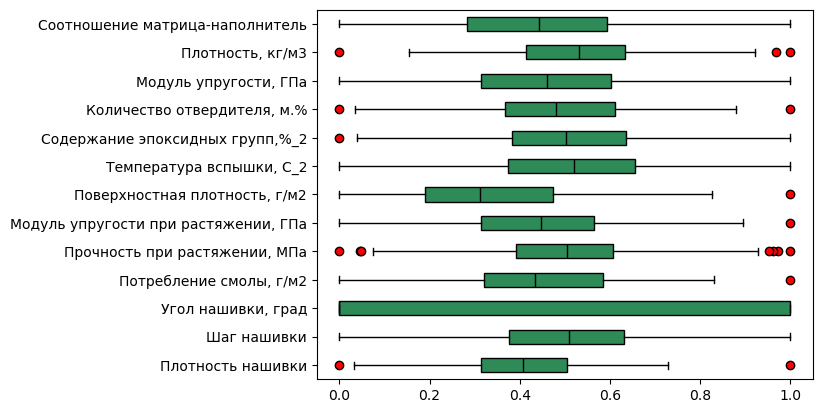

In [100]:
plt.boxplot(pd.DataFrame(scaler.transform(test_df)), 
            labels=df.columns, 
            patch_artist=True, 
            meanline=True, 
            vert=False, 
            boxprops=dict(facecolor='seagreen', color='black'), 
            medianprops=dict(color='black'), 
            whiskerprops=dict(color='black'), 
            capprops=dict(color = 'black'), 
            flierprops=dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
           )
plt.gca().invert_yaxis()
plt.show()

In [101]:
print('Количество значений в признаках: ', test_df.shape[0])

Количество значений в признаках:  205


Обработаем выбросы в нашей тестовой выборке:

In [102]:
test_df = iqr_method(test_df, test_df.columns)

In [103]:
print('Количество значений в признаках: ', test_df.shape[0])

Количество значений в признаках:  187


*Количество значений уменьшилось на **18 единиц**.*

Посмотрим на результаты после обработки:

In [104]:
scaled_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)
outliers = {}
total = 0

for column in scaled_df:
    Q1 = scaled_df[column].quantile(0.25)
    Q3 = scaled_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers[column] = ((scaled_df[column] < lower_bound) | (scaled_df[column] > upper_bound)).sum()
    total += outliers[column]

print(pd.DataFrame.from_dict(outliers, orient='index', columns=['Outlier Count']))
print("Общее количество возможных выбросов: ", total)

                                      Outlier Count
Соотношение матрица-наполнитель                   0
Плотность, кг/м3                                  0
Модуль упругости, ГПа                             0
Количество отвердителя, м.%                       0
Содержание эпоксидных групп,%_2                   0
Температура вспышки, С_2                          0
Поверхностная плотность, г/м2                     0
Модуль упругости при растяжении, ГПа              0
Прочность при растяжении, МПа                     1
Потребление смолы, г/м2                           0
Угол нашивки, град                                0
Шаг нашивки                                       0
Плотность нашивки                                 0
Общее количество возможных выбросов:  1


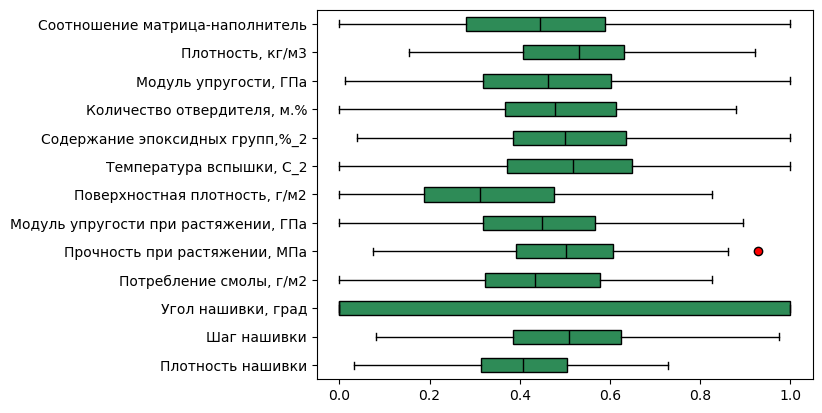

In [105]:
plt.boxplot(pd.DataFrame(scaler.transform(test_df)), 
            labels=df.columns, 
            patch_artist=True, 
            meanline=True, 
            vert=False, 
            boxprops=dict(facecolor='seagreen', color='black'), 
            medianprops=dict(color='black'), 
            whiskerprops=dict(color='black'), 
            capprops=dict(color = 'black'), 
            flierprops=dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none')
           )
plt.gca().invert_yaxis()
plt.show()

Тестовая выборка готова к дальнейшей работе.

Нормализуем данные по параметрам обучающей выборки:

In [106]:
scaler = MinMaxScaler()
scaler.fit(train_df)

train_df_norm = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns)
test_df_norm = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

Обучающая выборка у нас уже была разделена ранее и в ней ничего не менялось. Поэтому разделим только тестовую:

In [107]:
X_test, y_test_modulus, y_test_strength = (
    test_df_norm.drop(columns=['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']), 
    test_df_norm['Модуль упругости при растяжении, ГПа'], 
    test_df_norm['Прочность при растяжении, МПа']
)

Проверим размерности:

In [108]:
print("X_test: ", X_test.shape, ", y_test_modulus: ", y_test_modulus.shape, ", y_test_strength: ", y_test_strength.shape)

X_test:  (187, 11) , y_test_modulus:  (187,) , y_test_strength:  (187,)


In [109]:
correlations = test_df_norm.corr()

Посмотрим корреляцию признаков с модулем упругости при растяжении:

In [110]:
print(correlations['Модуль упругости при растяжении, ГПа'].sort_values(ascending=False))

Модуль упругости при растяжении, ГПа    1.000000
Прочность при растяжении, МПа           0.103303
Угол нашивки, град                      0.084216
Потребление смолы, г/м2                 0.055607
Поверхностная плотность, г/м2           0.046348
Модуль упругости, ГПа                   0.025663
Соотношение матрица-наполнитель         0.024556
Содержание эпоксидных групп,%_2         0.024192
Количество отвердителя, м.%             0.010316
Плотность нашивки                       0.006497
Шаг нашивки                             0.005753
Температура вспышки, С_2               -0.015668
Плотность, кг/м3                       -0.082992
Name: Модуль упругости при растяжении, ГПа, dtype: float64


А теперь корреляцию признаков с прочностью при растяжении:

In [111]:
print(correlations['Прочность при растяжении, МПа'].sort_values(ascending=False))

Прочность при растяжении, МПа           1.000000
Модуль упругости при растяжении, ГПа    0.103303
Угол нашивки, град                      0.082706
Модуль упругости, ГПа                   0.028859
Потребление смолы, г/м2                 0.028625
Температура вспышки, С_2                0.026228
Плотность нашивки                      -0.037551
Соотношение матрица-наполнитель        -0.040615
Содержание эпоксидных групп,%_2        -0.041283
Поверхностная плотность, г/м2          -0.044644
Плотность, кг/м3                       -0.084514
Шаг нашивки                            -0.094189
Количество отвердителя, м.%            -0.166117
Name: Прочность при растяжении, МПа, dtype: float64


*В целом, выглядит неплохо, но корреляции всё ещё весбма слабы.*

Попробуем найти общие корреляции для обоих признаков, в качестве минимального порога возьмём минимальную корреляцию из двух таблиц выше:

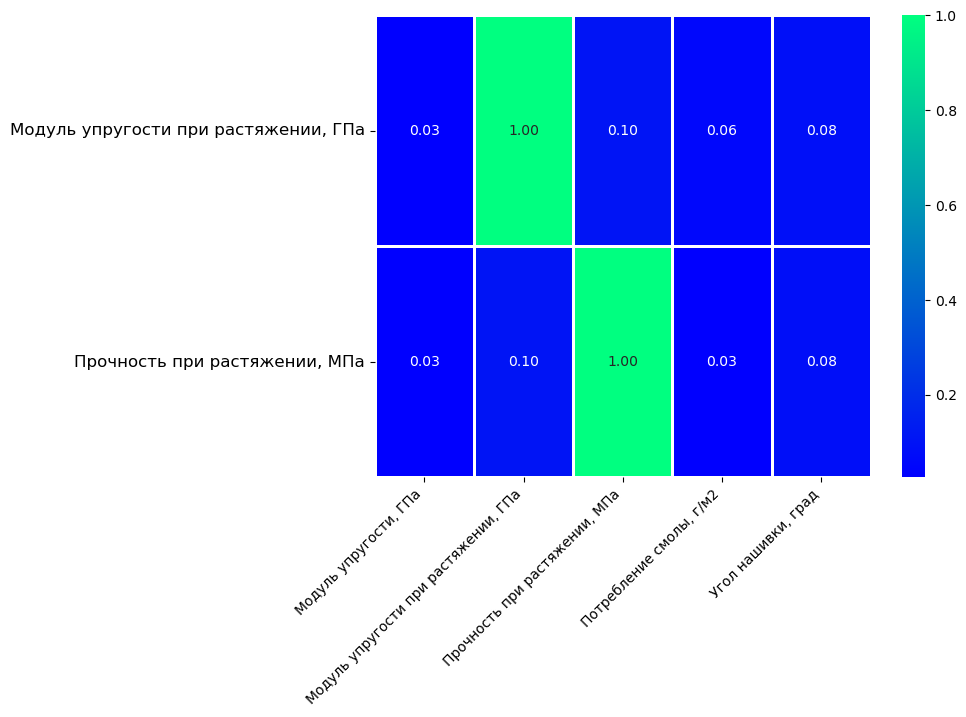

In [112]:
correlation_threshold = 0.005753
correlation_matrix = test_df_norm.corr()
target_corr = correlation_matrix[['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']]

useful_features = target_corr[
    (target_corr['Модуль упругости при растяжении, ГПа'] > correlation_threshold ) &
    (target_corr['Прочность при растяжении, МПа'] > correlation_threshold)
]

if useful_features.empty:
    print("Нет признаков с корреляцией выше заданного порога для обоих целевых признаков.")
else:
    plt.figure(figsize=(8, 6))
    sns.heatmap(useful_features.T, annot=True, cmap='winter', linewidths=1, linecolor='white', fmt=".2f",
                annot_kws={"size": 10})
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=12)
    plt.show()

*Общие взаимосвязи гораздо слабее, чем в данных обучающей выборки.*

Визуализируем графики ядерной оценки плотности признаков до нормализации и после:

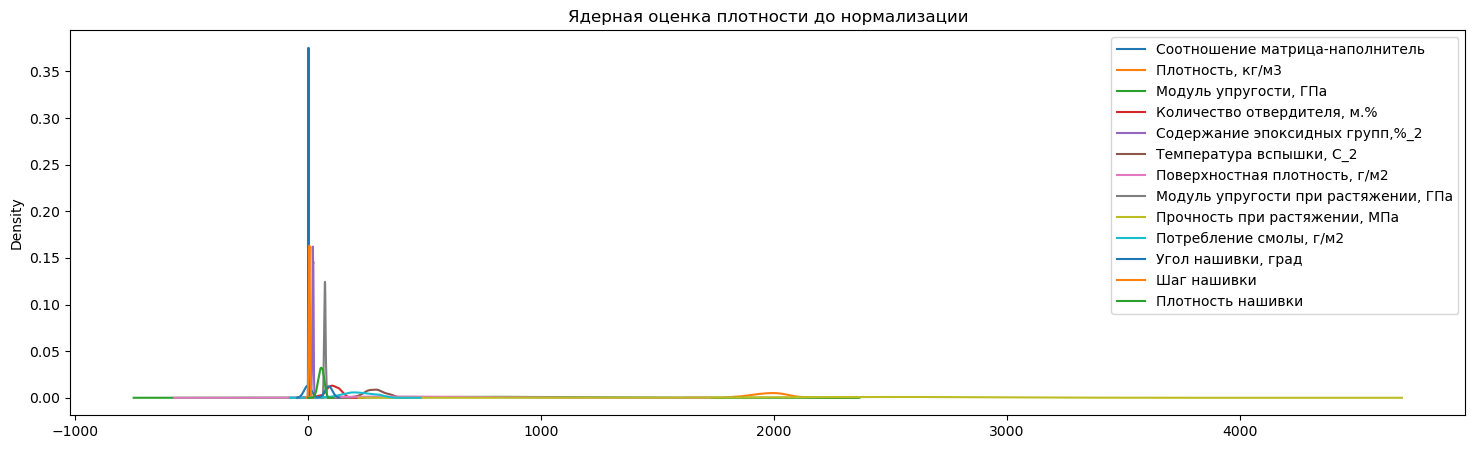

In [113]:
fig, ax = plt.subplots(figsize = (18, 5))
test_df.plot(kind = 'kde', ax = ax)
plt.title('Ядерная оценка плотности до нормализации')
plt.show()

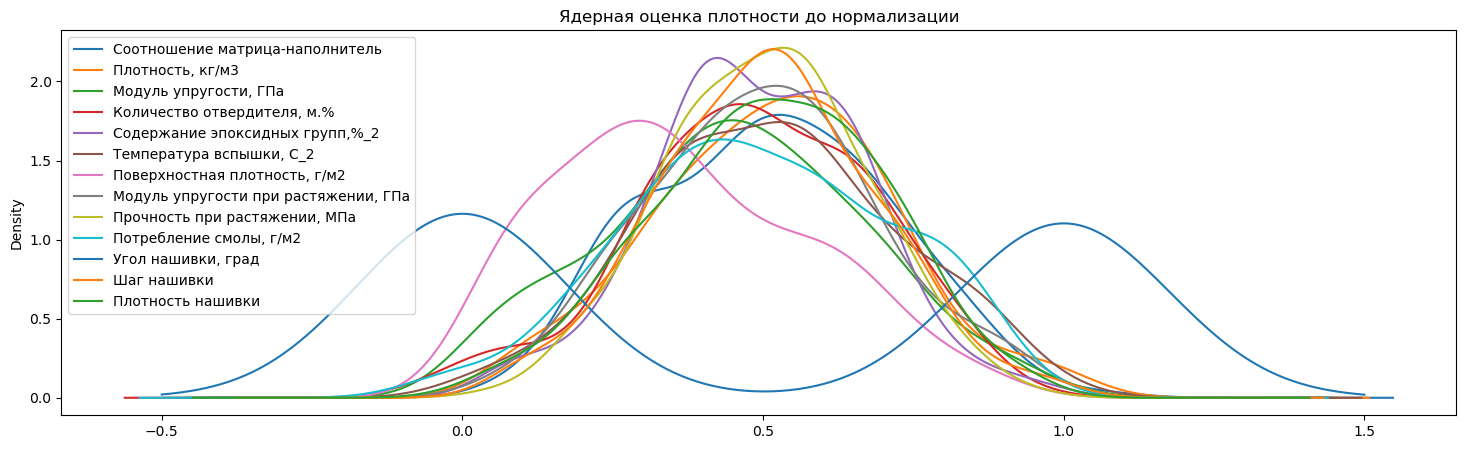

In [114]:
fig, ax = plt.subplots(figsize = (18, 5))
test_df_norm.plot(kind = 'kde', ax = ax)
plt.title('Ядерная оценка плотности до нормализации')
plt.show()

*Нормализовать обучающие данные получилось чуть лучше.*

#### Обучение #2

Снова создадим таблицу (к её названию добавим двойку) в которую будем складывать различные метрики для работы каждой модели:

In [115]:
metrics_modulus = ['MSEm', 'MAEm', 'R²m train', 'R²m test']
metrics_strength = ['MSEs', 'MAEs', 'R²s train', 'R²s test']
models = ['RandomForestRegressor', 'LinearRegression', 'LassoCV', 'ElasticNetCV', 'RidgeCV', 'KNeighborsRegressor', 
         'GradientBoostingRegressor', 'SVR']

ms_table_2 = pd.DataFrame(index=models, columns=metrics_modulus + metrics_strength)

Переопределим метод, чтобы складывать новые данные именно в новую таблицу:

In [116]:
def create_modulus_model(model, model_name):
    model.fit(X_train, y_train_modulus)
    y_pred_m = model.predict(X_test)
    
    # средняя квадратичная ошибка:
    mse = mean_squared_error(y_test_modulus, y_pred_m)
    ms_table_2.loc[model_name, 'MSEm'] = round(mse, 3)
    print("MSE для модуля упругости:", mse)
    
    #средняя абсолютная ошибка:
    mae = mean_absolute_error(y_test_modulus, y_pred_m)
    ms_table_2.loc[model_name, 'MAEm'] = round(mae, 3)
    print("MAE для модуля упругости:", mae)
    
    # коэффициент детерминации для обучающей выборки:
    r2_train = model.score(X_train, y_train_modulus)
    ms_table_2.loc[model_name, 'R²m train'] = round(r2_train, 3)
    print("R² на обучающей выборке для модуля упругости:", r2_train)
    
    # коэффициент детерминации для тестовой выборки:
    r2_test = r2_score(y_test_modulus, y_pred_m)
    ms_table_2.loc[model_name, 'R²m test'] = round(r2_test, 3)
    print("R² на тестовой выборке для модуля упругости:", r2_test)


def create_strength_model(model, model_name):
    model.fit(X_train, y_train_strength)
    y_pred_s = model.predict(X_test)
    
    # средняя квадратичная ошибка:
    mse = mean_squared_error(y_test_strength, y_pred_s)
    ms_table_2.loc[model_name, 'MSEs'] = round(mse, 3)
    print("MSE для прочности:", mse)
    
    #средняя абсолютная ошибка:
    mae = mean_absolute_error(y_test_strength, y_pred_s)
    ms_table_2.loc[model_name, 'MAEs'] = round(mae, 3)
    print("MAE для прочности:", mae)
    
    # коэффициент детерминации для обучающей выборки:
    r2_train = model.score(X_train, y_train_strength)
    ms_table_2.loc[model_name, 'R²s train'] = round(r2_train, 3)
    print("R² на обучающей выборке для прочности:", r2_train)
    
    # коэффициент детерминации для тестовой выборки:
    r2_test = r2_score(y_test_strength, y_pred_s)
    ms_table_2.loc[model_name, 'R²s test'] = round(r2_test, 3)
    print("R² на тестовой выборке для прочности:", r2_test)

Обучающая выборка у нас не менялась, поэтому нет смысла заново учить модели. Но у нас изменились тестовые данные, поэтому проверим уже готовые модели на работу с ними.

##### `RandomForestRegressor`:

In [117]:
create_modulus_model(model_rf, "RandomForestRegressor")

MSE для модуля упругости: 0.03707071206498135
MAE для модуля упругости: 0.15575841226445503
R² на обучающей выборке для модуля упругости: 0.23207512550246512
R² на тестовой выборке для модуля упругости: -0.028800055263065838


In [118]:
create_strength_model(model_rf, "RandomForestRegressor")

MSE для прочности: 0.026658586693681655
MAE для прочности: 0.13320688232624633
R² на обучающей выборке для прочности: 0.25652338745089487
R² на тестовой выборке для прочности: 0.01307820781311786


##### `LinearRegression`:

In [119]:
create_modulus_model(model_lr, "LinearRegression")

MSE для модуля упругости: 0.03617829143511401
MAE для модуля упругости: 0.15304480775954277
R² на обучающей выборке для модуля упругости: 0.015319361544065102
R² на тестовой выборке для модуля упругости: -0.0040332692429849715


In [120]:
create_strength_model(model_lr, "LinearRegression")

MSE для прочности: 0.02635100975182201
MAE для прочности: 0.13197542925040448
R² на обучающей выборке для прочности: 0.017640497742477557
R² на тестовой выборке для прочности: 0.02446494748478356


##### `LassoCV`

In [121]:
create_modulus_model(model_lasso, "LassoCV")

MSE для модуля упругости: 0.036172186937721715
MAE для модуля упругости: 0.15342580209952109
R² на обучающей выборке для модуля упругости: 0.0
R² на тестовой выборке для модуля упругости: -0.0038638549829204116


In [122]:
create_strength_model(model_lasso, "LassoCV")

MSE для прочности: 0.027012679753235288
MAE для прочности: 0.133189644353561
R² на обучающей выборке для прочности: 0.0
R² на тестовой выборке для прочности: -3.059502594759955e-05


##### `ElasticNetCV`

In [123]:
create_modulus_model(model_en, "ElasticNetCV")

MSE для модуля упругости: 0.036172186937721715
MAE для модуля упругости: 0.15342580209952109
R² на обучающей выборке для модуля упругости: 0.0
R² на тестовой выборке для модуля упругости: -0.0038638549829204116


In [124]:
create_strength_model(model_en, "ElasticNetCV")

MSE для прочности: 0.027012679753235288
MAE для прочности: 0.133189644353561
R² на обучающей выборке для прочности: 0.0
R² на тестовой выборке для прочности: -3.059502594759955e-05


##### `RidgeCV`

In [125]:
create_modulus_model(model_ridge, "RidgeCV")

MSE для модуля упругости: 0.03604589690573112
MAE для модуля упругости: 0.15291288468646103
R² на обучающей выборке для модуля упругости: 0.014131578258517852
R² на тестовой выборке для модуля упругости: -0.0003590074994586079


In [126]:
create_strength_model(model_ridge, "RidgeCV")

MSE для прочности: 0.026414958912457098
MAE для прочности: 0.13212368396880717
R² на обучающей выборке для прочности: 0.01631016623215864
R² на тестовой выборке для прочности: 0.022097499392053632


##### `KNeighborsRegressor`

In [127]:
create_modulus_model(model_knn_m, "KNeighborsRegressor")

MSE для модуля упругости: 0.03577428736671127
MAE для модуля упругости: 0.15197497419832365
R² на обучающей выборке для модуля упругости: 0.007379864852360529
R² на тестовой выборке для модуля упругости: 0.007178800467752544


In [128]:
create_strength_model(model_knn_s, "KNeighborsRegressor")

MSE для прочности: 0.02683186681999759
MAE для прочности: 0.1328276873442355
R² на обучающей выборке для прочности: -0.0008040476359763016
R² на тестовой выборке для прочности: 0.006663241604326964


##### `GradientBoostingRegressor`

In [129]:
create_modulus_model(model_gb, "GradientBoostingRegressor")

MSE для модуля упругости: 0.03696649037842216
MAE для модуля упругости: 0.1554105012189614
R² на обучающей выборке для модуля упругости: 0.08458967864202382
R² на тестовой выборке для модуля упругости: -0.02590765663031891


In [130]:
create_strength_model(model_gb, "GradientBoostingRegressor")

MSE для прочности: 0.026816098537769575
MAE для прочности: 0.13427824190408258
R² на обучающей выборке для прочности: 0.09501811046429531
R² на тестовой выборке для прочности: 0.00724699578210819


##### `SVR`

In [131]:
create_modulus_model(model_svr_m, "SVR")

MSE для модуля упругости: 0.03611937360683795
MAE для модуля упругости: 0.152568812911489
R² на обучающей выборке для модуля упругости: 0.041105989527494224
R² на тестовой выборке для модуля упругости: -0.002398159971813252


In [132]:
create_strength_model(model_svr_s, "SVR")

MSE для прочности: 0.02712819169002401
MAE для прочности: 0.13360602084692277
R² на обучающей выборке для прочности: 0.002960356683914589
R² на тестовой выборке для прочности: -0.004306937541191269


Отсортируем таблицу по результатам коэффициентов детерминации (в тестовой выборке) для обеих целевых переменных:

In [219]:
ms_table_2.sort_values(['R²m test', 'R²s test'], ascending=False)

,MSEm,MAEm,R²m train,R²m test,MSEs,MAEs,R²s train,R²s test
KNeighborsRegressor,0.036,0.152,0.007,0.007,0.027,0.133,-0.001,0.007
RidgeCV,0.036,0.153,0.014,-0.0,0.026,0.132,0.016,0.022
SVR,0.036,0.153,0.041,-0.002,0.027,0.134,0.003,-0.004
LinearRegression,0.036,0.153,0.015,-0.004,0.026,0.132,0.018,0.024
LassoCV,0.036,0.153,0.0,-0.004,0.027,0.133,0.0,-0.0
ElasticNetCV,0.036,0.153,0.0,-0.004,0.027,0.133,0.0,-0.0
GradientBoostingRegressor,0.037,0.155,0.085,-0.026,0.027,0.134,0.095,0.007
RandomForestRegressor,0.037,0.155,0.24,-0.028,0.027,0.133,0.253,0.016


Выведем также таблицу из первой гипотезы:

In [220]:
ms_table.sort_values(['R²m test', 'R²s test'], ascending=False)

,MSEm,MAEm,R²m train,R²m test,MSEs,MAEs,R²s train,R²s test
KNeighborsRegressor,0.037,0.154,0.007,0.009,0.033,0.143,-0.001,0.007
RidgeCV,0.037,0.154,0.014,0.007,0.033,0.143,0.016,0.013
SVR,0.037,0.154,0.041,0.006,0.034,0.144,0.003,-0.007
LinearRegression,0.037,0.154,0.015,0.005,0.033,0.143,0.018,0.013
LassoCV,0.037,0.155,0.0,-0.002,0.034,0.144,0.0,-0.0
ElasticNetCV,0.037,0.155,0.0,-0.002,0.034,0.144,0.0,-0.0
GradientBoostingRegressor,0.038,0.156,0.085,-0.019,0.033,0.145,0.095,0.01
RandomForestRegressor,0.039,0.158,0.238,-0.039,0.034,0.144,0.25,0.003


Значения метрик для моделей не особо изменились. Коэффициет всё также мал и признаки всё также мало как помогают моделям уловить взимосвязи.

***Вывод:***    
В сравнении с первой гипотезой, мы никуда особо не продвинулись. Предсказать целевые значения модели всё также не могут.

**ОБНОВЛЕНИЕ:** сохраним модель LinearRegression для прочности при растяжении, так как в конце исследования становится ясно, что это лучшая модель по показателям.

In [233]:
model_lr.fit(X_train, y_train_strength)

LinearRegression()

In [234]:
pickle.dump({'model': model_lr, 'scaler': scaler}, open("./models/strength_model_with_scaler.pkl", 'wb'))

In [235]:
class StrengthModelWithScaler:
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler

    def predict(self, X):
        X_full = X.copy()
        
        missing_columns = ['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']
        for col in missing_columns:
            if col not in X_full.columns:
                X_full[col] = 0

        X_denorm = self.scaler.inverse_transform(X_full)
        X_denorm_df = pd.DataFrame(X_denorm, columns=X_full.columns)

        X_denorm_df = X_denorm_df.drop(columns=missing_columns, errors='ignore')

        y_pred = self.model.predict(X_denorm_df)
        return y_pred.flatten()

In [236]:
loaded_data = pickle.load(open("./models/strength_model_with_scaler.pkl", 'rb'))

In [237]:
strength_model = StrengthModelWithScaler(loaded_data['model'], loaded_data['scaler'])

In [238]:
prediction = strength_model.predict(X_test)

In [239]:
prediction[0]

-147.67910883923975

Модель рабочая, хоть предсказание и так себе.

### Третья гипотеза

Признаки, которые весьма слабо коррелируют с целевыми значениями или не коррелируют совсем, только мешают обучению моделей и, соответственно, их предсказательной способности. Поэтому стоит оставить только те переменные, которые имеют хоть какую-то положительную связь с модулем упругости и прочностью.

Ещё раз посмотрим с какими признаками коррелируют целевые значения в обучающей и тестовой выборках.

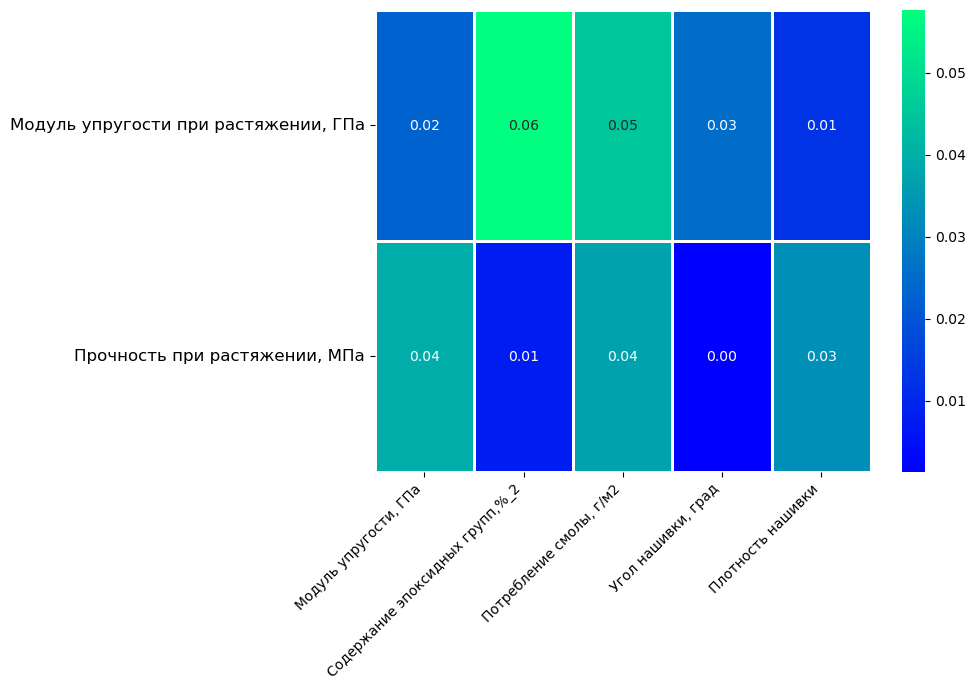

In [241]:
correlation_threshold = 0.001326
correlation_matrix = train_df.corr()
target_corr = correlation_matrix[['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']]

useful_features = target_corr[
    (target_corr['Модуль упругости при растяжении, ГПа'] > correlation_threshold ) &
    (target_corr['Прочность при растяжении, МПа'] > correlation_threshold)
]

if useful_features.empty:
    print("Нет признаков с корреляцией выше заданного порога для обоих целевых признаков.")
else:
    plt.figure(figsize=(8, 6))
    sns.heatmap(useful_features.T, annot=True, cmap='winter', linewidths=1, linecolor='white', fmt=".2f",
                annot_kws={"size": 10})
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=12)
    plt.show()

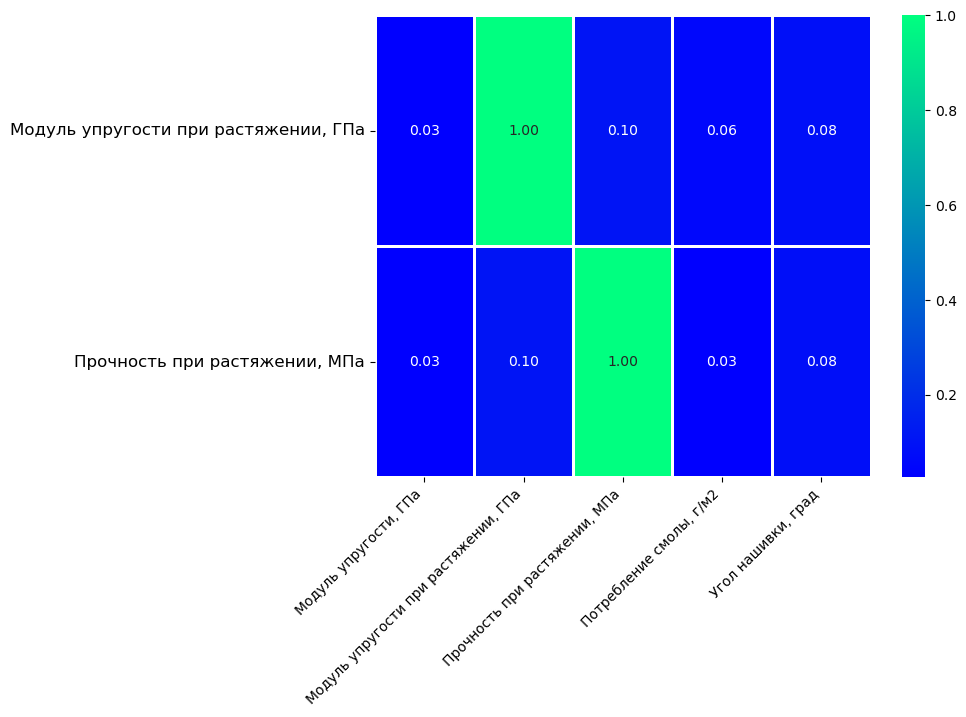

In [242]:
correlation_threshold = 0.005753
correlation_matrix = test_df.corr()
target_corr = correlation_matrix[['Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа']]

useful_features = target_corr[
    (target_corr['Модуль упругости при растяжении, ГПа'] > correlation_threshold ) &
    (target_corr['Прочность при растяжении, МПа'] > correlation_threshold)
]

if useful_features.empty:
    print("Нет признаков с корреляцией выше заданного порога для обоих целевых признаков.")
else:
    plt.figure(figsize=(8, 6))
    sns.heatmap(useful_features.T, annot=True, cmap='winter', linewidths=1, linecolor='white', fmt=".2f",
                annot_kws={"size": 10})
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=12)
    plt.show()

*В наших выборках только три признака совпадают в плане наличия корреляции (очень маленькой!) с целевыми значениями: "Модуль упругости, ГПА", "Потребление смолы, г/м2" и "Угол нашивки, град".*

Данные уже были нормализованы ранее, поэтому сразу переходим к разделению выборок, оставляя только нужные нам данные, которые мы определили выше.

Разделим тренировочную выборку для модуля упругости при растяжении и прочности при растяжении:

In [243]:
X_train, y_train_modulus, y_train_strength = (
    train_df_norm[['Модуль упругости, ГПа', 'Потребление смолы, г/м2', 'Угол нашивки, град']], 
    train_df_norm['Модуль упругости при растяжении, ГПа'], 
    train_df_norm['Прочность при растяжении, МПа']
)

Разделим тестовую выборку для модуля упругости при растяжении и прочности при растяжении:

In [244]:
X_test, y_test_modulus, y_test_strength = (
    test_df_norm[['Модуль упругости, ГПа', 'Потребление смолы, г/м2', 'Угол нашивки, град']], 
    test_df_norm['Модуль упругости при растяжении, ГПа'], 
    test_df_norm['Прочность при растяжении, МПа']
)

Проверим размерности:

In [245]:
print("X_train: ", X_train.shape, ", y_train_modulus: ", y_train_modulus.shape, ", y_train_strength: ", y_train_strength.shape)
print("X_test: ", X_test.shape, ", y_test_modulus: ", y_test_modulus.shape, ", y_test_strength: ", y_test_strength.shape)

X_train:  (746, 3) , y_train_modulus:  (746,) , y_train_strength:  (746,)
X_test:  (187, 3) , y_test_modulus:  (187,) , y_test_strength:  (187,)


#### Обучение #3

И снова шаг за шагом повторим наши действия из прошлых гипотез. Но в отличие от второй попытки, здесь мы будем обучать модели заново, так как признаки в выборках изменились. 

Создадим таблицу под номером три:

In [246]:
metrics_modulus = ['MSEm', 'MAEm', 'R²m train', 'R²m test']
metrics_strength = ['MSEs', 'MAEs', 'R²s train', 'R²s test']
models = ['RandomForestRegressor', 'LinearRegression', 'LassoCV', 'ElasticNetCV', 'RidgeCV', 'KNeighborsRegressor', 
         'GradientBoostingRegressor', 'SVR']

ms_table_3 = pd.DataFrame(index=models, columns=metrics_modulus + metrics_strength)

Снова переопределим метод:

In [247]:
def create_modulus_model(model, model_name):
    model.fit(X_train, y_train_modulus)
    y_pred_m = model.predict(X_test)
    
    # средняя квадратичная ошибка:
    mse = mean_squared_error(y_test_modulus, y_pred_m)
    ms_table_3.loc[model_name, 'MSEm'] = round(mse, 3)
    print("MSE для модуля упругости:", mse)
    
    #средняя абсолютная ошибка:
    mae = mean_absolute_error(y_test_modulus, y_pred_m)
    ms_table_3.loc[model_name, 'MAEm'] = round(mae, 3)
    print("MAE для модуля упругости:", mae)
    
    # коэффициент детерминации для обучающей выборки:
    r2_train = model.score(X_train, y_train_modulus)
    ms_table_3.loc[model_name, 'R²m train'] = round(r2_train, 3)
    print("R² на обучающей выборке для модуля упругости:", r2_train)
    
    # коэффициент детерминации для тестовой выборки:
    r2_test = r2_score(y_test_modulus, y_pred_m)
    ms_table_3.loc[model_name, 'R²m test'] = round(r2_test, 3)
    print("R² на тестовой выборке для модуля упругости:", r2_test)


def create_strength_model(model, model_name):
    model.fit(X_train, y_train_strength)
    y_pred_s = model.predict(X_test)
    
    # средняя квадратичная ошибка:
    mse = mean_squared_error(y_test_strength, y_pred_s)
    ms_table_3.loc[model_name, 'MSEs'] = round(mse, 3)
    print("MSE для прочности:", mse)
    
    #средняя абсолютная ошибка:
    mae = mean_absolute_error(y_test_strength, y_pred_s)
    ms_table_3.loc[model_name, 'MAEs'] = round(mae, 3)
    print("MAE для прочности:", mae)
    
    # коэффициент детерминации для обучающей выборки:
    r2_train = model.score(X_train, y_train_strength)
    ms_table_3.loc[model_name, 'R²s train'] = round(r2_train, 3)
    print("R² на обучающей выборке для прочности:", r2_train)
    
    # коэффициент детерминации для тестовой выборки:
    r2_test = r2_score(y_test_strength, y_pred_s)
    ms_table_3.loc[model_name, 'R²s test'] = round(r2_test, 3)
    print("R² на тестовой выборке для прочности:", r2_test)

И приступим к обучению моделей!

##### `RandomForestRegressor:`

Для начала подберём подходящие значения n_estimators и max_depth для моделей Случайного Леса:

In [235]:
various = {'n_estimators': [100, 200], 
           'max_depth': [5, 10, 15, 20]}

results_m = GridSearchCV(RandomForestRegressor(), various, cv=9, n_jobs=-1, verbose=1)
results_m.fit(X_train, y_train_modulus)
print("Лучшее значение n_estimators для модуля упругости: ", results_m.best_params_)

results_s = GridSearchCV(RandomForestRegressor(), various, cv=9, n_jobs=-1, verbose=1)
results_s.fit(X_train, y_train_strength)
print("Лучшее значение n_estimators для прочности: ", results_s.best_params_)

Fitting 9 folds for each of 8 candidates, totalling 72 fits
Лучшее значение n_estimators для модуля упругости:  {'max_depth': 5, 'n_estimators': 200}
Fitting 9 folds for each of 8 candidates, totalling 72 fits
Лучшее значение n_estimators для прочности:  {'max_depth': 5, 'n_estimators': 100}


In [248]:
model_rf_m = RandomForestRegressor(max_depth=5, n_estimators=200)
model_rf_s = RandomForestRegressor(max_depth=5, n_estimators=100)

In [249]:
create_modulus_model(model_rf_m, "RandomForestRegressor")

MSE для модуля упругости: 0.03625902685623815
MAE для модуля упругости: 0.15242500259844904
R² на обучающей выборке для модуля упругости: 0.159604229795962
R² на тестовой выборке для модуля упругости: -0.006273868386821313


In [250]:
create_strength_model(model_rf_s, "RandomForestRegressor")

MSE для прочности: 0.02845298258236596
MAE для прочности: 0.134716082314307
R² на обучающей выборке для прочности: 0.18148953771933507
R² на тестовой выборке для прочности: -0.053351735630688735


##### `LinearRegression`:

In [251]:
model_lr = LinearRegression()

In [252]:
create_modulus_model(model_lr, "LinearRegression")

MSE для модуля упругости: 0.035912531354069646
MAE для модуля упругости: 0.1524437057632514
R² на обучающей выборке для модуля упругости: 0.0032985478720575223
R² на тестовой выборке для модуля упругости: 0.003342202411994122


In [253]:
create_strength_model(model_lr, "LinearRegression")

MSE для прочности: 0.026978298611154028
MAE для прочности: 0.13270421819800174
R² на обучающей выборке для прочности: 0.002982023497877573
R² на тестовой выборке для прочности: 0.001242221824778733


##### `LassoCV`:

In [254]:
model_lasso = LassoCV()

In [255]:
create_modulus_model(model_lasso, "LassoCV")

MSE для модуля упругости: 0.036172186937721715
MAE для модуля упругости: 0.15342580209952109
R² на обучающей выборке для модуля упругости: 0.0
R² на тестовой выборке для модуля упругости: -0.0038638549829204116


In [256]:
create_strength_model(model_lasso, "LassoCV")

MSE для прочности: 0.027012679753235288
MAE для прочности: 0.133189644353561
R² на обучающей выборке для прочности: 0.0
R² на тестовой выборке для прочности: -3.059502594759955e-05


##### `ElasticNetCV`:

In [257]:
model_en = ElasticNetCV()

In [258]:
create_modulus_model(model_en, "ElasticNetCV")

MSE для модуля упругости: 0.036172186937721715
MAE для модуля упругости: 0.15342580209952109
R² на обучающей выборке для модуля упругости: 0.0
R² на тестовой выборке для модуля упругости: -0.0038638549829204116


In [259]:
create_strength_model(model_en, "ElasticNetCV")

MSE для прочности: 0.027012679753235288
MAE для прочности: 0.133189644353561
R² на обучающей выборке для прочности: 0.0
R² на тестовой выборке для прочности: -3.059502594759955e-05


##### `RidgeCV`:

In [260]:
model_ridge = RidgeCV()

In [261]:
create_modulus_model(model_ridge, "RidgeCV")

MSE для модуля упругости: 0.03592857157770623
MAE для модуля упругости: 0.15257186973814288
R² на обучающей выборке для модуля упругости: 0.003121522507070984
R² на тестовой выборке для модуля упругости: 0.0028970482176311485


In [262]:
create_strength_model(model_ridge, "RidgeCV")

MSE для прочности: 0.026960330230205925
MAE для прочности: 0.13277371133353705
R² на обучающей выборке для прочности: 0.002782599330114044
R² на тестовой выборке для прочности: 0.0019074253830829724


##### `KNeighborsRegressor`:

Для начала подберём подходящие значения n_neighbors для моделей KNN:

In [262]:
various = {'n_neighbors': range(1, 501)}

results_m = GridSearchCV(KNeighborsRegressor(), various, cv=9, n_jobs=-1, verbose=1)
results_m.fit(X_train, y_train_modulus)
print("Лучшее значение n_neighbors для модуля упругости: ", results_m.best_params_)

results_s = GridSearchCV(KNeighborsRegressor(), various, cv=9, n_jobs=-1, verbose=1)
results_s.fit(X_train, y_train_strength)
print("Лучшее значение n_neighbors для прочности: ", results_s.best_params_)

Fitting 9 folds for each of 500 candidates, totalling 4500 fits
Лучшее значение n_neighbors для модуля упругости:  {'n_neighbors': 318}
Fitting 9 folds for each of 500 candidates, totalling 4500 fits
Лучшее значение n_neighbors для прочности:  {'n_neighbors': 425}


In [263]:
model_knn_m = KNeighborsRegressor(n_neighbors=318)
model_knn_s = KNeighborsRegressor(n_neighbors=425)

In [264]:
create_modulus_model(model_knn_m, "KNeighborsRegressor")

MSE для модуля упругости: 0.03604955543507823
MAE для модуля упругости: 0.15304035224421053
R² на обучающей выборке для модуля упругости: 0.0011349574100060211
R² на тестовой выборке для модуля упругости: -0.00046054035342391053


In [265]:
create_strength_model(model_knn_s, "KNeighborsRegressor")

MSE для прочности: 0.02708728300413901
MAE для прочности: 0.13337520393654606
R² на обучающей выборке для прочности: 0.0009216584137302641
R² на тестовой выборке для прочности: -0.0027924658982065864


##### `GradientBoostingRegressor`:

Для начала подберём подходящие значения n_estimators, max_depth и learning_rate для градиентного бустинга:

In [257]:
various = {
    'n_estimators': [100, 200], 
    'max_depth': [3, 5, 7], 
    'learning_rate': [0.01, 0.05, 0.1]
}

results_m = GridSearchCV(GradientBoostingRegressor(), various, cv=9, n_jobs=-1, verbose=1)
results_m.fit(X_train, y_train_modulus)
print("Лучшие значения для модуля упругости: ", results_m.best_params_)

results_s = GridSearchCV(GradientBoostingRegressor(), various, cv=9, n_jobs=-1, verbose=1)
results_s.fit(X_train, y_train_strength)
print("Лучшие значения для прочности: ", results_s.best_params_)

Fitting 9 folds for each of 18 candidates, totalling 162 fits
Лучшие значения для модуля упругости:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Fitting 9 folds for each of 18 candidates, totalling 162 fits
Лучшие значения для прочности:  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}


In [310]:
model_gb_m = GradientBoostingRegressor(learning_rate=0.01, max_depth=3, n_estimators=100)
model_gb_s = GradientBoostingRegressor(learning_rate=0.01, max_depth=5, n_estimators=100)

In [311]:
create_modulus_model(model_gb_m, "GradientBoostingRegressor")

MSE для модуля упругости: 0.035878495547294637
MAE для модуля упругости: 0.15230526978431044
R² на обучающей выборке для модуля упругости: 0.06068211732192563
R² на тестовой выборке для модуля упругости: 0.0042867766578211786


In [312]:
create_strength_model(model_gb_s, "GradientBoostingRegressor")

MSE для прочности: 0.027621446276584506
MAE для прочности: 0.13450247197311055
R² на обучающей выборке для прочности: 0.15956666128122965
R² на тестовой выборке для прочности: -0.02256760927770407


##### `SVR`:

Для начала подберём подходящие значения kernel и C для моделей метода опорных векторов:

In [263]:
various = {'C': np.logspace(-3, 2, 6), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

results_m = GridSearchCV(SVR(), various, cv=9, n_jobs=-1, verbose=1)
results_m.fit(X_train, y_train_modulus)
print("Лучшие значения для модуля упругости: ", results_m.best_params_)

results_s = GridSearchCV(SVR(), various, cv=9, n_jobs=-1, verbose=1)
results_s.fit(X_train, y_train_strength)
print("Лучшие значения для прочности: ", results_s.best_params_)

Fitting 9 folds for each of 24 candidates, totalling 216 fits
Лучшие значения для модуля упругости:  {'C': 0.001, 'kernel': 'sigmoid'}
Fitting 9 folds for each of 24 candidates, totalling 216 fits
Лучшие значения для прочности:  {'C': 0.001, 'kernel': 'sigmoid'}


In [269]:
model_svr = SVR(kernel='sigmoid', C=0.001)

In [270]:
create_modulus_model(model_svr, "SVR")

MSE для модуля упругости: 0.036220543656038336
MAE для модуля упругости: 0.153605691365438
R² на обучающей выборке для модуля упругости: -6.92983756389598e-05
R² на тестовой выборке для модуля упругости: -0.005205868440586903


In [271]:
create_strength_model(model_svr, "SVR")

MSE для прочности: 0.02706636466105069
MAE для прочности: 0.133358008826331
R² на обучающей выборке для прочности: -0.000914356882584233
R² на тестовой выборке для прочности: -0.0020180524273230027


Отсортируем таблицу по результатам коэффициентов детерминации (в тестовой выборке) для обеих целевых переменных:

In [267]:
ms_table_3.sort_values(['R²m test', 'R²s test'], ascending=False)

,MSEm,MAEm,R²m train,R²m test,MSEs,MAEs,R²s train,R²s test
GradientBoostingRegressor,0.036,0.152,0.061,0.004,0.028,0.134,0.16,-0.021
RidgeCV,0.036,0.153,0.003,0.003,0.027,0.133,0.003,0.002
LinearRegression,0.036,0.152,0.003,0.003,0.027,0.133,0.003,0.001
KNeighborsRegressor,0.036,0.153,0.001,-0.0,0.027,0.133,0.001,-0.003
LassoCV,0.036,0.153,0.0,-0.004,0.027,0.133,0.0,-0.0
ElasticNetCV,0.036,0.153,0.0,-0.004,0.027,0.133,0.0,-0.0
SVR,0.036,0.154,-0.0,-0.005,0.027,0.133,-0.001,-0.002
RandomForestRegressor,0.036,0.152,0.163,-0.007,0.028,0.134,0.175,-0.033


Также выведем на экран две предыдущие таблицы для сравнения:

In [268]:
ms_table.sort_values(['R²m test', 'R²s test'], ascending=False)

,MSEm,MAEm,R²m train,R²m test,MSEs,MAEs,R²s train,R²s test
KNeighborsRegressor,0.037,0.154,0.007,0.009,0.033,0.143,-0.001,0.007
RidgeCV,0.037,0.154,0.014,0.007,0.033,0.143,0.016,0.013
SVR,0.037,0.154,0.041,0.006,0.034,0.144,0.003,-0.007
LinearRegression,0.037,0.154,0.015,0.005,0.033,0.143,0.018,0.013
LassoCV,0.037,0.155,0.0,-0.002,0.034,0.144,0.0,-0.0
ElasticNetCV,0.037,0.155,0.0,-0.002,0.034,0.144,0.0,-0.0
GradientBoostingRegressor,0.038,0.156,0.085,-0.019,0.033,0.145,0.095,0.01
RandomForestRegressor,0.039,0.158,0.238,-0.039,0.034,0.144,0.25,0.003


In [269]:
ms_table_2.sort_values(['R²m test', 'R²s test'], ascending=False)

,MSEm,MAEm,R²m train,R²m test,MSEs,MAEs,R²s train,R²s test
KNeighborsRegressor,0.036,0.152,0.007,0.007,0.027,0.133,-0.001,0.007
RidgeCV,0.036,0.153,0.014,-0.0,0.026,0.132,0.016,0.022
SVR,0.036,0.153,0.041,-0.002,0.027,0.134,0.003,-0.004
LinearRegression,0.036,0.153,0.015,-0.004,0.026,0.132,0.018,0.024
LassoCV,0.036,0.153,0.0,-0.004,0.027,0.133,0.0,-0.0
ElasticNetCV,0.036,0.153,0.0,-0.004,0.027,0.133,0.0,-0.0
GradientBoostingRegressor,0.037,0.155,0.085,-0.026,0.027,0.134,0.095,0.007
RandomForestRegressor,0.037,0.155,0.24,-0.028,0.027,0.133,0.253,0.016


***Вывод:***    
В сравнении с предыдущими гипотезами, модель KNeighborsRegressor неплохо себя показала. Но всё также далеко от приемлемых результатов.

**ОБНОВЛЕНИЕ:** сохраним модель GradientBoostingRegressor для модуля упругости, так как в конце исследования становится ясно, что это лучшая модель по показателям.

In [313]:
pickle.dump({'model': model_gb_m, 'scaler': scaler}, open("./models/modulus_model_with_scaler.pkl", 'wb'))

In [337]:
class ModulusModelWithScaler:
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler

    def predict(self, X):
        X_full = X.copy()
        
        missing_columns = ['Соотношение матрица-наполнитель', 'Плотность, кг/м3', 
                           'Количество отвердителя, м.%', 'Содержание эпоксидных групп,%_2', 
                           'Температура вспышки, С_2', 'Поверхностная плотность, г/м2', 
                           'Модуль упругости при растяжении, ГПа', 'Прочность при растяжении, МПа', 
                           'Шаг нашивки', 'Плотность нашивки']
        for col in missing_columns:
            if col not in X_full.columns:
                X_full[col] = 0

        X_full = X_full[self.scaler.feature_names_in_]
        X_denorm = self.scaler.inverse_transform(X_full)
        X_denorm_df = pd.DataFrame(X_denorm, columns=X_full.columns)
        
        X_denorm_df = X_denorm_df.drop(columns=missing_columns, errors='ignore')

        y_pred = self.model.predict(X_denorm_df)
        return y_pred.flatten()

In [338]:
loaded_data = pickle.load(open("./models/modulus_model_with_scaler.pkl", 'rb'))

In [339]:
modulus_model = ModulusModelWithScaler(loaded_data['model'], loaded_data['scaler'])

In [340]:
prediction = modulus_model.predict(X_test)

In [341]:
prediction[0]

0.48345677523690006

*Модель сохранена, но не уверена, что верно получилось денормализовать данные.*

# Вывод по сделанной работе

При реальной работе с подобными таблицами, я бы однозначно обращалась за дополнительными данными к заказчику, там как их недостаточно по количеству, а также связи между признаками и целевыми переменными практически нет.

***Модуль упругости:***    
Лучшая модель для прогноза модуля упругости - `GradientBoostingRegressor` из *третьей* гипотезы, так как эта модель показала наибольший R² (0.004) при низком MSE (0.036) на тестовых данных.

***Прочность при растяжении:***    
Лучшая модель для прогноза прочности при растяжении - `LinearRegression` из *второй* гипотезы, так как эта модель показала наибольший R² (0.024) при низком MSE (0.026) на тестовых данных.

Впрочем, ни одна из получившихся моделей не может быть использована для точных пресказаний и не демонстрируют надёжные результаты.

Несмотря на это, считаю поставленную задачу выполненной.    
Спасибо за внимание!